<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

<h2 style="text-align: center;"><b>Часть 2. Проведение топологического анлиза данных (TDA)</b></h2>

# Предварительные процедуры

## Загрузка библиотек

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import tarfile
from scipy.sparse import csr_matrix
import os
from collections import Counter, defaultdict
from node2vec import Node2Vec 
import warnings
from collections import deque
from glob import glob
import community as community_louvain
import gudhi as gd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from gudhi.representations import PersistenceImage
from matplotlib.patches import Patch
from scipy import stats
import pickle
import time
from scipy.sparse.csgraph import shortest_path
warnings.filterwarnings('ignore')

## Загрузка данных

In [3]:
def load_combined(data_dir="facebook_data"):    

    print("Загрузка полного графа")
    G_combined = nx.Graph()    
    with open(os.path.join(data_dir, "facebook_combined.txt"), 'r') as f:
        for line in f:
            if line.strip():
                node1, node2 = map(int, line.strip().split())
                G_combined.add_edge(node1, node2)  
    return G_combined

In [4]:
G_combined = load_combined()

Загрузка полного графа


In [5]:
def load_all_facebook_ego_networks(data_dir="facebook_data"):
    
    facebook_dir = os.path.join(data_dir)
    edge_files = glob(os.path.join(facebook_dir, "*.edges"))    
    ego_networks = {}
    
    for edge_file in edge_files:
        ego_id = os.path.basename(edge_file).split('.')[0]      
        ego_data = load_single_ego_network(facebook_dir, ego_id)
        
        if ego_data:
            ego_networks[ego_id] = ego_data
    
    return ego_networks

def load_single_ego_network(data_dir, ego_id):
 
    base_path = os.path.join(data_dir, ego_id)
    
    ego_data = {
        'id': ego_id,
        'graph': None,
        'circles': {},
        'node_features': None,
        'ego_features': None,
        'feat_names': None,
        'node_ids': None
    }
    
    edges_file = f"{base_path}.edges"
    if os.path.exists(edges_file):
        try:
            edges = pd.read_csv(edges_file, sep=' ', header=None, names=['node1', 'node2'])
            ego_data['edges'] = edges

            G = nx.Graph()
            for _, row in edges.iterrows():
                G.add_edge(row['node1'], row['node2'])

            ego_node = int(ego_id)
            G.add_node(ego_node)
            for friend in edges['node1'].unique():
                if friend != ego_node:
                    G.add_edge(ego_node, friend)
            
            ego_data['graph'] = G
        except Exception as e:
            print(f"  Ошибка загрузки рёбер: {e}")
            return None
    
    circles_file = f"{base_path}.circles"
    if os.path.exists(circles_file):
        circles = {}
        try:
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle_name = parts[0]
                        members = list(map(int, parts[1:]))
                        circles[circle_name] = members
            ego_data['circles'] = circles
        except Exception as e:
            print(f"  Ошибка загрузки кругов: {e}")
    
    feat_file = f"{base_path}.feat"
    if os.path.exists(feat_file):
        try:
            node_features_data = np.loadtxt(feat_file)
            if len(node_features_data.shape) == 1:
                node_features_data = node_features_data.reshape(1, -1)
            
            node_ids = node_features_data[:, 0].astype(int)
            node_features = node_features_data[:, 1:]
            
            ego_data['node_features'] = node_features
            ego_data['node_ids'] = node_ids
        except Exception as e:
            print(f"  Ошибка загрузки фичей узлов: {e}")
    
    egofeat_file = f"{base_path}.egofeat"
    if os.path.exists(egofeat_file):
        try:
            ego_features = np.loadtxt(egofeat_file)
            ego_data['ego_features'] = ego_features
        except Exception as e:
            print(f"  Ошибка загрузки эго-фичей: {e}")
    
    featnames_file = f"{base_path}.featnames"
    if os.path.exists(featnames_file):
        try:
            with open(featnames_file, 'r') as f:
                feat_names = []
                for line in f:
                    line = line.strip()
                    if ' ' in line:
                        parts = line.split(' ', 1)
                        feat_names.append(parts[1])
                    else:
                        feat_names.append(line)
            ego_data['feat_names'] = feat_names
        except Exception as e:
            print(f"  Ошибка загрузки названий фичей: {e}")
    
    return ego_data

In [6]:
ego_networks = load_all_facebook_ego_networks()

# 2. Топологический анализ

### Experimental Setup
Для изучения геометрической структуры графа был проведён двухуровневый TDA, основанный на построении комплекса Виеториса-Рипса (VR-комплекса): **локальный** (на ego-networks) и **глобальный** (на выборке из всего графа).

## 2.1 Локальный TDA

## Последовательность проведения:

* Построение комплекса Виеториса-Рипса (VR-комплекс)
* Построение персистентных диаграмм  
* Извлечение топологических инвариантов  
* Использовать TDA фичи для анализа классификации пользовательских кругов (circles)

**Ключевое наблюдение при проведениее TDA на графе (структурный TDA):**
мера расстояние "кратчайший путь" не сработала, поскольку все узлы на расстоянии 1 или 2 от ego (получилась буквально бинарная метрика), поэтому нет топологической структуры и отсутствовали циклы H1. Вместо этого использована альтернативная метрика - рассстояние Жаккара (Jaccard), учитывающая сходство окружения (общих друзей) для узла. Расстояние между узлами *u* и *v* рассчитывалось как 


$$jaccard(u, v) = 1 - \frac{|neighbors(u) ∩ neighbors(v)|} {|neighbors(u) ∪ neighbors(v)|}$$

Такая метрика дает непрерывные значения в отрезке [0, 1]. Поскольку цель проведения TDA - обнаружение структурных сообществ, то в данном случае используется обоснование:
`Сообщество = группа с общими друзьями`

### Функции для работы

In [7]:
def build_VR (dist_matrix, max_edge_len):
    try:        
        rips = gd.RipsComplex(distance_matrix = dist_matrix, max_edge_length=max_edge_len)        
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence(min_persistence=0.001)  
        
        return rips, simplex_tree, persistence          
    except Exception as e:
        print(f"  Ошибка построения VR: {e}")


In [9]:
def compute_PD(simplex_tree):
    persistence = simplex_tree.persistence()

    persistence_by_dim = {}
    for dim in range(3):  
        persistence_by_dim[dim] = [
            (birth, death) for (d, (birth, death)) in persistence 
            if d == dim and death != float('inf')  
        ]
    
    print(f"  H0 (компоненты): {len(persistence_by_dim[0])} точек")
    print(f"  H1 (циклы): {len(persistence_by_dim[1])} точек")
    
    return persistence_by_dim

In [10]:
def visualize_PD (persistence_by_dim, title="Персистентные диаграммы"):

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    dimensions = ['H0 (компоненты)', 'H1 (циклы)']
    colors = ['blue', 'red']
    
    for dim, (ax, dim_name, color) in enumerate(zip(axes, dimensions, colors)):
        points = persistence_by_dim[dim]
        
        if points:
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            
            ax.scatter(births, deaths, alpha=0.6, color=color, s=30)
            
            # birth-death
            max_val = max(max(births + deaths), 1.0) if births else 1.0
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)
            
            stable_points = sum(1 for b, d in points if (d - b) > max_val * 0.1)
            ax.set_title(f"{dim_name}\n{len(points)} точек, {stable_points} устойчивых")
        
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death' if dim == 0 else '')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(f'tda_diagrams/EGO-{ego_id} {title}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [14]:
def extract_topoinvariants(persistence_by_dim, distance_matrix=None, G=None):
    invariants = {}
    
    # Бетти (2 не будет)
    for dim in [0, 1]:
        points = persistence_by_dim.get(dim, [])
        invariants[f'betti_{dim}'] = len(points)
        
        if points:
            births = np.array([p[0] for p in points])
            deaths = np.array([p[1] for p in points])
            lifetimes = deaths - births
            
            # Персистентная статистика
            invariants[f'dim{dim}_mean_lifetime'] = float(np.mean(lifetimes))
    
    if persistence_by_dim.get(1):
        lifetimes_h1 = [d - b for b, d in persistence_by_dim[1]]
        # порог для устойчивых связей 0.2
        invariants[f'h1_persistent_above_0.2'] = sum(1 for lt in lifetimes_h1 if lt > 0.2)
    
    # инварианты графа
    if G is not None:
        invariants.update({
            'clustering': nx.average_clustering(G),
            'assortativity': nx.degree_assortativity_coefficient(G),
            'diameter': nx.diameter(G) if nx.is_connected(G) else None
        })    
    
    return invariants

## TDA pipeline

In [15]:
def tda_pipeline(ego_data, ego_id=None):
    
    print("="*70)
    print(f"TDA analysis for ego-network {ego_id}")
    print("="*70)
    
    G = ego_data['graph']
    circles = ego_data.get('circles', {})
    node_features = ego_data.get('node_features', None)
    
    results = {
        'ego_id': ego_id
    }
    
    # Расстояние Жаккара - работает, кратчайшие пути - нет
    print("\n1. TDA на графе (структурная топология):")
    try:
        n_nodes = G.number_of_nodes()
        node_list = list(G.nodes())
        jaccard_matrix = np.zeros((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            neighbors_i = set(G.neighbors(node_list[i]))
            for j in range(i+1, n_nodes):
                neighbors_j = set(G.neighbors(node_list[j]))
                
                if neighbors_i or neighbors_j:
                    intersection = len(neighbors_i & neighbors_j)
                    union = len(neighbors_i | neighbors_j)
                    similarity = intersection / union if union > 0 else 0
                    distance = 1 - similarity
                else:
                    distance = 1.0
                
                jaccard_matrix[i, j] = distance
                jaccard_matrix[j, i] = distance

                
        rips, simplex_tree, persistence = build_VR(jaccard_matrix, 0.8)
        
        persistence_dict = {0: [], 1: []}
        h1_points = []
        
        for dim, (birth, death) in persistence:
            if dim in persistence_dict and death != float('inf'):
                persistence_dict[dim].append((birth, death))
                if dim == 1:
                    h1_points.append((birth, death))
        
        counts = {dim: len(points) for dim, points in persistence_dict.items()}
                
        print(f"  H0: {counts[0]}, H1: {counts[1]}")
        
        if h1_points:
            lifetimes = [d - b for b, d in h1_points]
            
            print(f"  Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")
            
            persistence_by_dim = {}
            for dim in [0, 1]:
                persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence 
                                           if d == dim and death != float('inf')]
            
            visualize_PD(persistence_by_dim, title=f"Graph Persistance Diagramm")
   
        
        results['graph_tda'] = {
            'distance_matrix': jaccard_matrix,
            'persistence': persistence_dict,
            'counts': counts,
            'h1_points': h1_points
        }
        
    except Exception as e:
        print(f"  Ошибка: {e}")
    

    if node_features is not None:
        print("\n2. TDA на эмбеддингах (семантическая топология):")      
        try:
            # Подготовка эмбеддингов
            feat_node_ids = ego_data.get('node_ids', [])
            if len(feat_node_ids) > 0:
                node_to_feat_idx = {node_id: i for i, node_id in enumerate(feat_node_ids)}
                graph_nodes = sorted(list(G.nodes()))
                
                embeddings_list = []
                for node in graph_nodes:
                    if node in node_to_feat_idx:
                        embeddings_list.append(node_features[node_to_feat_idx[node]])
                    else:
                        embeddings_list.append(np.zeros(node_features.shape[1]))
                
                embeddings = np.array(embeddings_list)

                distance_matrix = euclidean_distances(embeddings)
                non_zero_dists = distance_matrix[distance_matrix > 0]
                
                if len(non_zero_dists) > 0:
                    max_edge_length = np.percentile(non_zero_dists, 85)
                else:
                    max_edge_length = 5.0


                rips_emb, simplex_tree_emb, persistence_emb = build_VR(distance_matrix,max_edge_length)

                persistence_dict_emb = {0: [], 1: []}
                h1_points_emb = []
                
                for dim, (birth, death) in persistence_emb:
                    if dim in persistence_dict_emb and death != float('inf'):
                        persistence_dict_emb[dim].append((birth, death))
                        if dim == 1:
                            h1_points_emb.append((birth, death))
                
                counts_emb = {dim: len(points) for dim, points in persistence_dict_emb.items()}
                
                print(f"  H0: {counts_emb[0]}, H1: {counts_emb[1]}")
                
                if h1_points_emb:
                    lifetimes = [d - b for b, d in h1_points_emb]
                    print(f"  Среднее время жизни циклов: {np.mean(lifetimes):.4f}")
                    print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")

                for dim in [0, 1]:
                    persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence_emb 
                                               if d == dim and death != float('inf')]
                visualize_PD(persistence_by_dim, title=f"Embedding Persistance Diagramm")
                
                results['embedding_tda'] = {
                    'distance_matrix': distance_matrix,
                    'persistence': persistence_dict_emb,  
                    'h1_points': h1_points_emb,
                    'embeddings': embeddings
                }
        
        except Exception as e:
            print(f"  Ошибка: {e}")
    

    print("\n3. Извлечение топо-фичей:")
    
    try:
        if 'graph_tda' in results:
            jaccard_matrix = results['graph_tda']['distance_matrix']
            n_nodes = jaccard_matrix.shape[0]
            
            node_features_topo = []
            
            for i in range(n_nodes):
                features = []               

                jaccard_dists = jaccard_matrix[i]
                
                features.append(np.mean(jaccard_dists[jaccard_dists > 0]))
                features.append(np.min(jaccard_dists[jaccard_dists > 0]))                
                features.append(np.std(jaccard_dists[jaccard_dists > 0]))
                
                close_neighbors = np.sum(jaccard_dists < 0.5)
                features.append(close_neighbors)
                
                node_features_topo.append(features)
            
            topo_features = np.array(node_features_topo)
            
            results['topological_features'] = {
                'jaccard_based': topo_features,
                'node_ids': sorted(list(G.nodes())),
                'feature_names': [
                    'mean_jaccard_distance',
                    'min_jaccard_distance', 
                    'std_jaccard_distance',
                    'close_neighbors_count'
                ]
            }
    except Exception as e:
        print(f"  Ошибка: {e}")
        results['topological_features'] = {}
    


    print("\n4. Извлечение топологических инвариантов:")
    
    # Инварианты графа
    if 'graph_tda' in results and 'persistence' in results['graph_tda']:
       
        persistence_by_dim = results['graph_tda']['persistence']         
        
        graph_invariants = extract_topoinvariants(persistence_by_dim, results['graph_tda'].get('distance_matrix'), G)              
        results['graph_tda']['invariants'] = graph_invariants
        
        print(f"  Инварианты графа:")      
        for key, value in graph_invariants.items():
            print(f"    {key}: {value}")

       
    # Инварианты эмбеддингов
    if 'embedding_tda' in results and 'persistence' in results['embedding_tda']:
        persistence_by_dim_emb = results['embedding_tda']['persistence']          
        emb_invariants = extract_topoinvariants(persistence_by_dim_emb, results['embedding_tda'].get('distance_matrix'))
        
        results['embedding_tda']['invariants'] = emb_invariants   
        
        print(f"  Инварианты эмбеддингов:")
        for key, value in emb_invariants.items():
            print(f"    {key}: {value}")       
    
    if circles and 'topological_features' in results:
        print("\n5. Сравнение с пользовательскими кругами:")
        
        # Гипотеза 1: Круги - структурные сообщества в графе
        
        print("\n  5.1. Структурная топология vs круги:")
        
        try:
            structural_features = results['topological_features']['jaccard_based']
            node_ids = results['topological_features']['node_ids']
            
            labels = np.zeros(len(node_ids))
            node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
            
            for circle_idx, (circle_name, members) in enumerate(circles.items()):
                for member in members:
                    if member in node_to_idx:
                        labels[node_to_idx[member]] = circle_idx + 1

            mask = labels > 0
            if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                silhouette_structural = silhouette_score(structural_features[mask], labels[mask].astype(int))                            
                print(f"    Силуэтный коэффициент (структурный): {silhouette_structural:.3f}")
                
                if silhouette_structural > 0.3:
                    print(f"    Круги соответствуют структурным сообществам")
                elif silhouette_structural > 0:
                    print(f"    Слабая структурная корреляция")
                else:
                    print(f"    Круги НЕ соответствуют структурным сообществам")
        
        except Exception as e:
            print(f"    Ошибка структурного сравнения: {e}")
        

        # Гипотеза 2: Круги - семантические кластеры в пространстве признаков

        if 'embedding_tda' in results and 'embeddings' in results['embedding_tda']:
            print("\n  5.2. Семантическая топология vs круги:")
            
            try:
                embeddings = results['embedding_tda']['embeddings']  # (334, 224)
                
                if 'node_ids' in results['topological_features']:
                    node_ids = results['topological_features']['node_ids']
                    labels = np.zeros(len(node_ids))
                    node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                    
                    for circle_idx, (circle_name, members) in enumerate(circles.items()):
                        for member in members:
                            if member in node_to_idx:
                                labels[node_to_idx[member]] = circle_idx + 1
                    
                    mask = labels > 0
                    if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                        silhouette_semantic = silhouette_score(embeddings[mask], labels[mask].astype(int))                                          
                        print(f"    Силуэтный коэффициент (семантический): {silhouette_semantic:.3f}")

                        if silhouette_semantic > 0.3:
                            print(f"    Круги соответствуют семантическим кластерам")
                        elif silhouette_semantic > 0:
                            print(f"    Слабая семантическая корреляция")
                        else:
                            print(f"    Круги НЕ соответствуют семантическим кластерам")
                
                            
            except Exception as e:
                print(f"    Ошибка семантического сравнения: {e}")
        

        print("\n  5.3. Визуализация сравнений:")
        
        try:
            if 'topological_features' in results and 'embedding_tda' in results:
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))

                structural_features = results['topological_features']['jaccard_based']
                embeddings = results['embedding_tda']['embeddings']
                node_ids = results['topological_features']['node_ids']

                labels = np.zeros(len(node_ids))
                node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                
                for circle_idx, (circle_name, members) in enumerate(circles.items()):
                    for member in members:
                        if member in node_to_idx:
                            labels[node_to_idx[member]] = circle_idx + 1
                
                ax = axes[0, 0]
                if structural_features.shape[1] >= 2:
                    scatter = ax.scatter(
                        structural_features[:, 0], 
                        structural_features[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('Mean Jaccard distance')
                    ax.set_ylabel('Min Jaccard distance')
                    ax.set_title('Structural features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')

                ax = axes[0, 1]
                if embeddings.shape[1] >= 2:
                    
                    # PCA для уплощения пространства                    
                    if embeddings.shape[1] > 2:
                        pca = PCA(n_components=2)
                        embeddings_2d = pca.fit_transform(embeddings)
                    else:
                        embeddings_2d = embeddings
                    
                    scatter = ax.scatter(
                        embeddings_2d[:, 0], 
                        embeddings_2d[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('PC1')
                    ax.set_ylabel('PC2')
                    ax.set_title('Semantic features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')
                

                ax = axes[1, 0]
                comparison_data = []

                if 'silhouette_structural' in locals():
                    comparison_data.append(('Структурный', silhouette_structural))
                
                if 'silhouette_semantic' in locals():
                    comparison_data.append(('Семантический', silhouette_semantic))
                
                if comparison_data:
                    names, values = zip(*comparison_data)
                    colors = ['skyblue' if v > 0 else 'lightcoral' for v in values]
                    bars = ax.bar(names, values, color=colors, alpha=0.7)
                    
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
                    ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, 
                              label='Хорошая кластеризация (0.3)')
                    ax.set_ylabel('Silhouette')
                    ax.set_title('Сравнение качества кластеризации кругов')
                    ax.legend()
                    
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom')
                        
                ax = axes[1, 1]
                circle_stats = []
                circle_names = []
                
                for circle_name, members in circles.items():
                    member_indices = [node_to_idx[m] for m in members if m in node_to_idx]
                    if member_indices:

                        if structural_features.shape[1] > 0:
                            circle_features = structural_features[member_indices]
                            avg_similarity = 1 - np.mean(circle_features[:, 0])  
                            circle_stats.append(avg_similarity)
                            circle_names.append(circle_name[:10]) 
            
                if circle_stats:
                    bars = ax.bar(range(len(circle_stats)), circle_stats, alpha=0.7)
                    ax.set_xlabel('Circles')
                    ax.set_ylabel('Средняя структурная схожесть')
                    ax.set_title('Структурная сплоченность кругов')
                    ax.set_xticks(range(len(circle_names)))
                    ax.set_xticklabels(circle_names, rotation=45, ha='right', fontsize=8)
                
                plt.tight_layout()
                plt.savefig(f'tda_diagrams/EGO-{ego_id} Circles Comparison.png', dpi=150, bbox_inches='tight')
                plt.show()
        
        except Exception as e:
            print(f"    Ошибка визуализации: {e}")
        
    return results

### Запуск

TDA analysis for ego-network 0

1. TDA на графе (структурная топология):
  H0: 328, H1: 104
  Среднее время жизни: 0.0337
  Максимальное время жизни: 0.1333


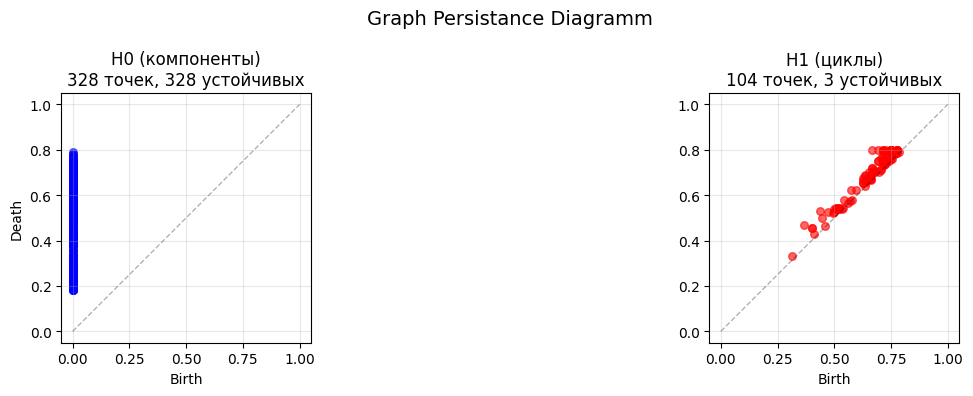


2. TDA на эмбеддингах (семантическая топология):
  H0: 280, H1: 14
  Среднее время жизни циклов: 0.2306
  Максимальное время жизни: 0.5040


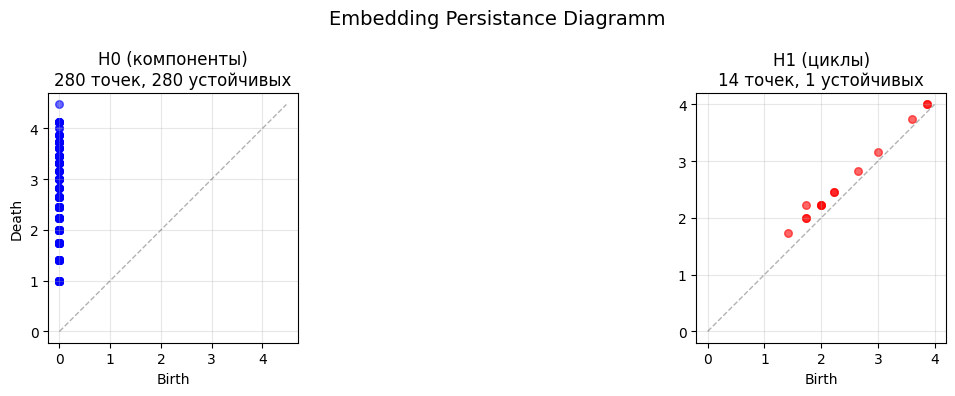


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 328
    dim0_mean_lifetime: 0.5187103796034828
    betti_1: 104
    dim1_mean_lifetime: 0.0337072827825933
    h1_persistent_above_0.2: 0
    clustering: 0.6820047114277947
    assortativity: -0.13706153977889127
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 280
    dim0_mean_lifetime: 2.353517262957143
    betti_1: 14
    dim1_mean_lifetime: 0.23056379684287023
    h1_persistent_above_0.2: 9

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.742
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.200
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


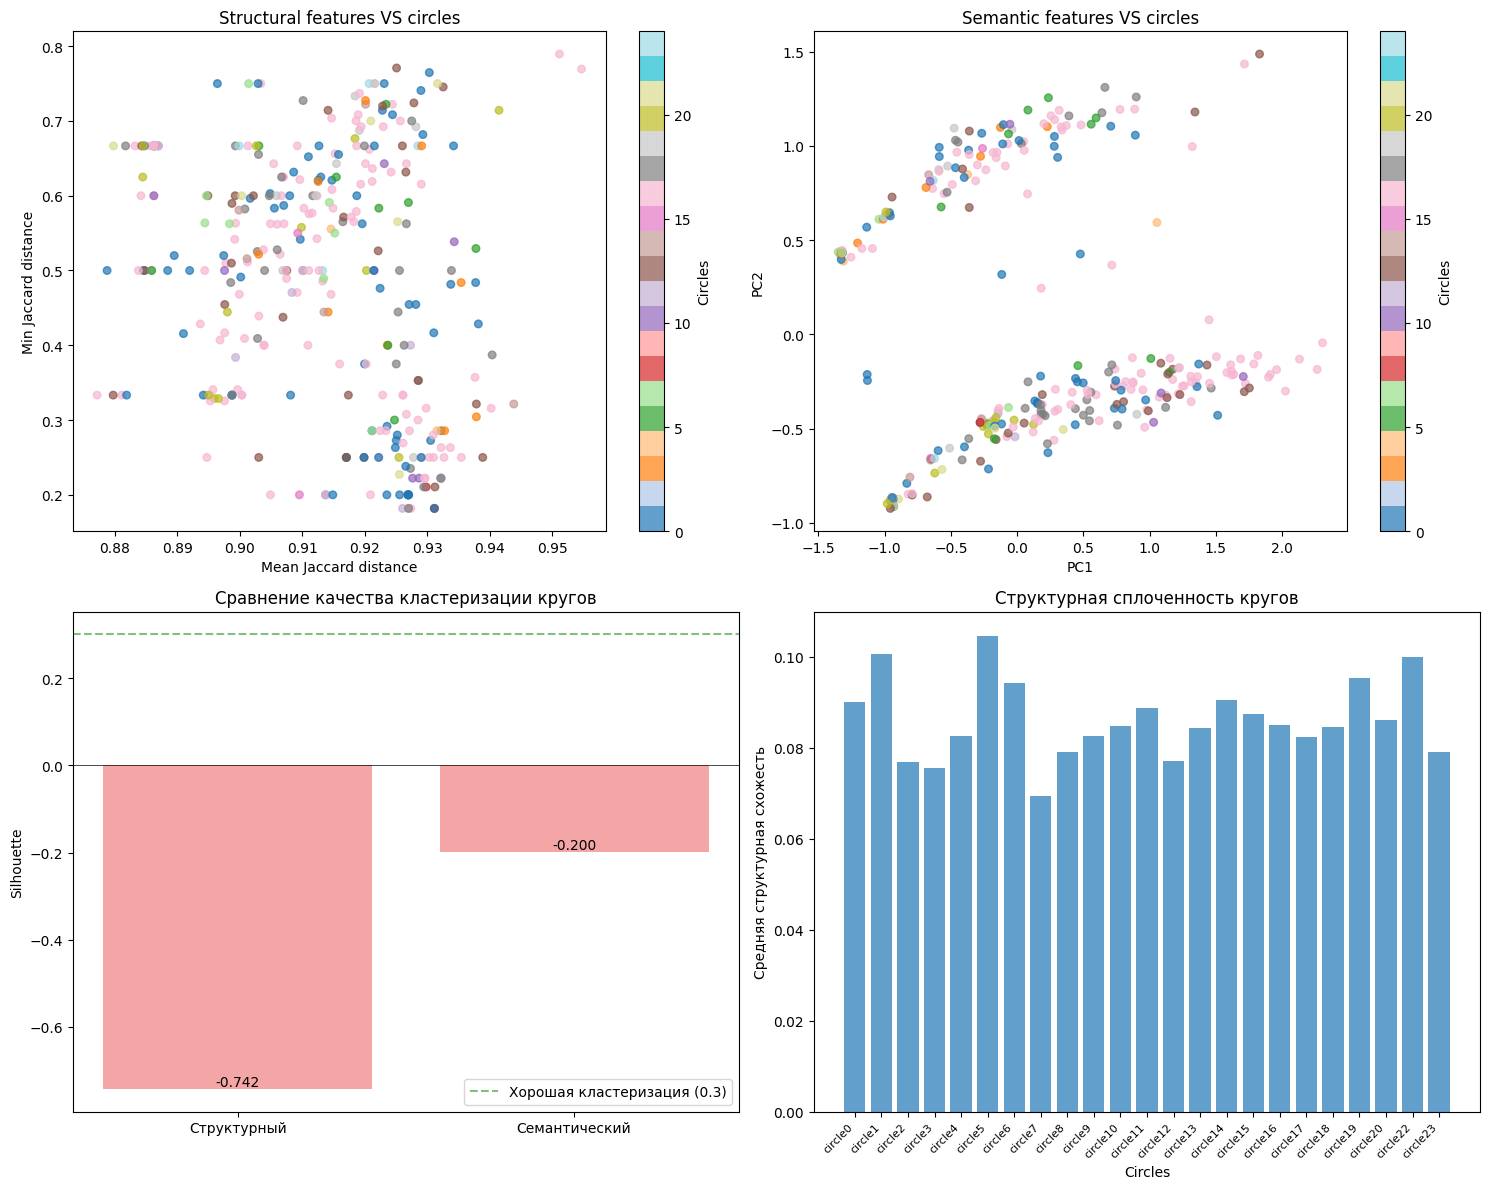

TDA analysis for ego-network 107

1. TDA на графе (структурная топология):
  H0: 1019, H1: 283
  Среднее время жизни: 0.0214
  Максимальное время жизни: 0.1128


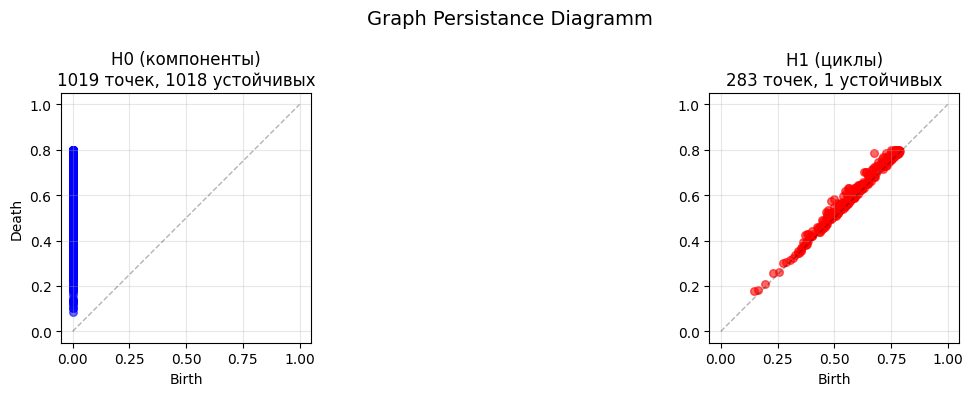


2. TDA на эмбеддингах (семантическая топология):
  H0: 956, H1: 106
  Среднее время жизни циклов: 0.2245
  Максимальное время жизни: 0.4142


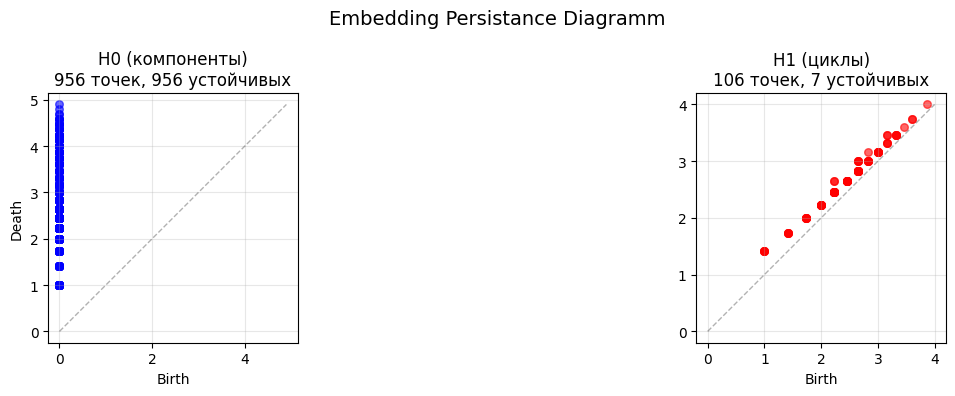


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 1019
    dim0_mean_lifetime: 0.5103486330794706
    betti_1: 283
    dim1_mean_lifetime: 0.02143758707449379
    h1_persistent_above_0.2: 0
    clustering: 0.5816952417873341
    assortativity: -0.022609120356929475
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 956
    dim0_mean_lifetime: 2.578801203792763
    betti_1: 106
    dim1_mean_lifetime: 0.22451798759137323
    h1_persistent_above_0.2: 51

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.301
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.051
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


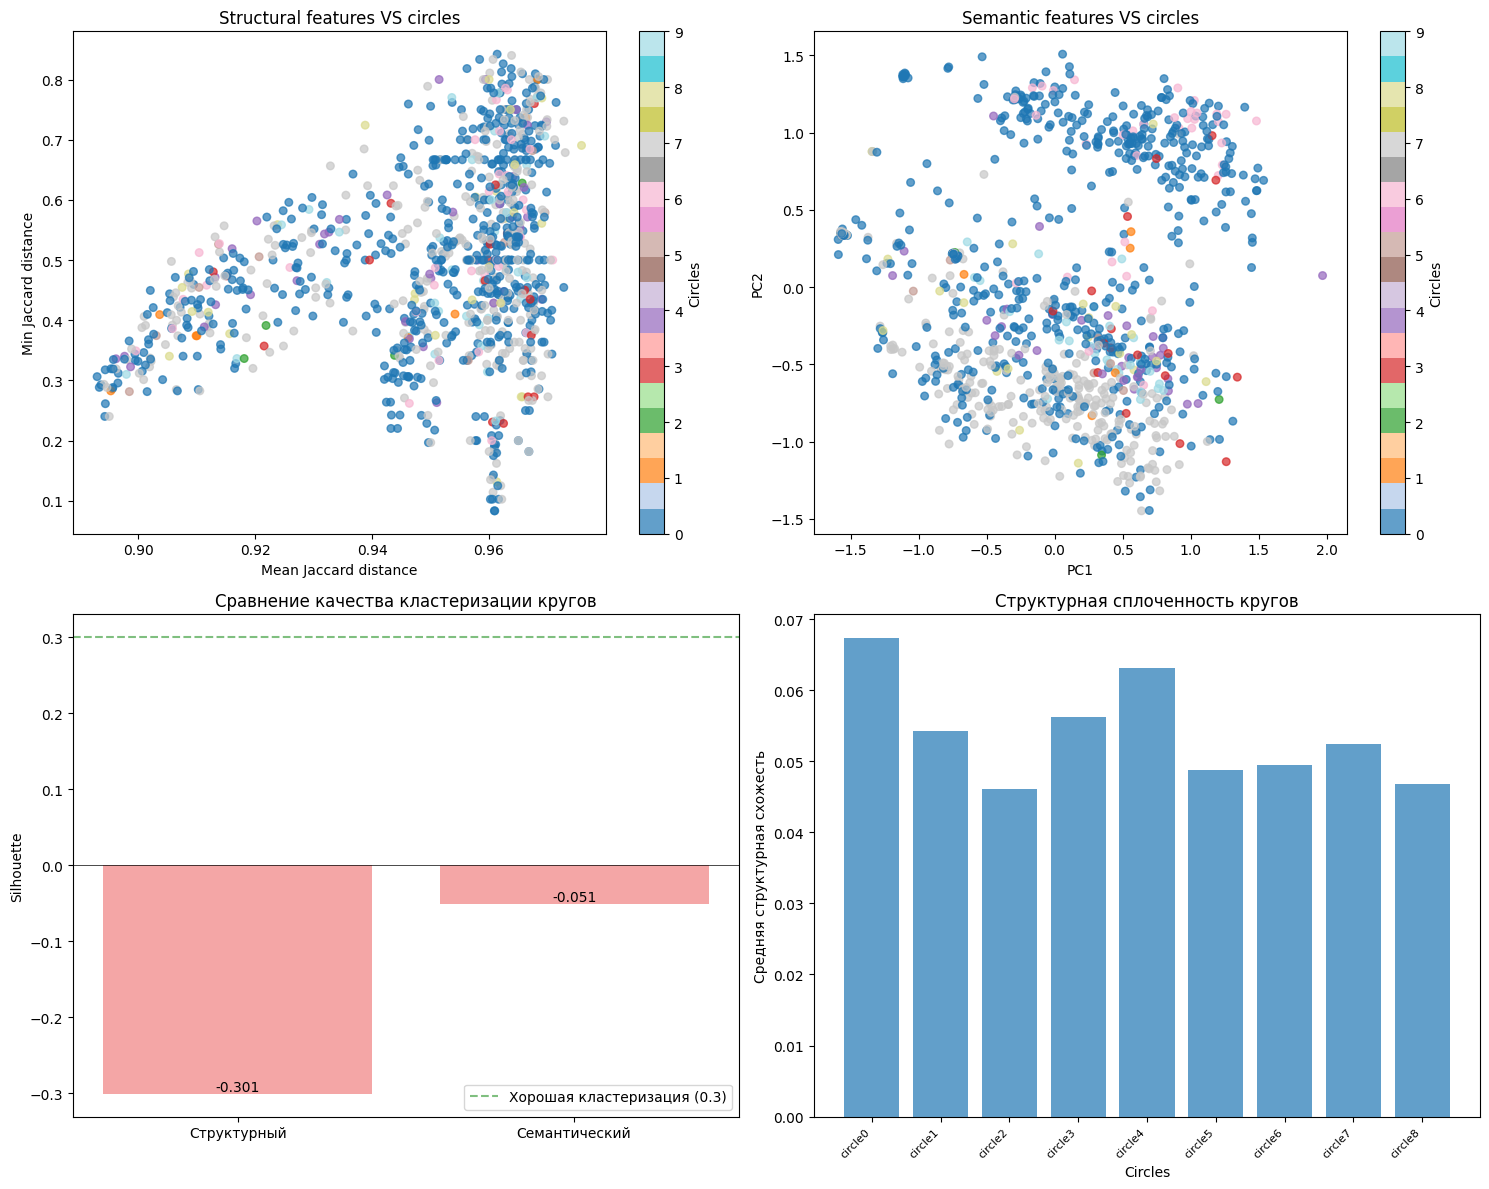

TDA analysis for ego-network 1684

1. TDA на графе (структурная топология):
  H0: 738, H1: 218
  Среднее время жизни: 0.0224
  Максимальное время жизни: 0.0972


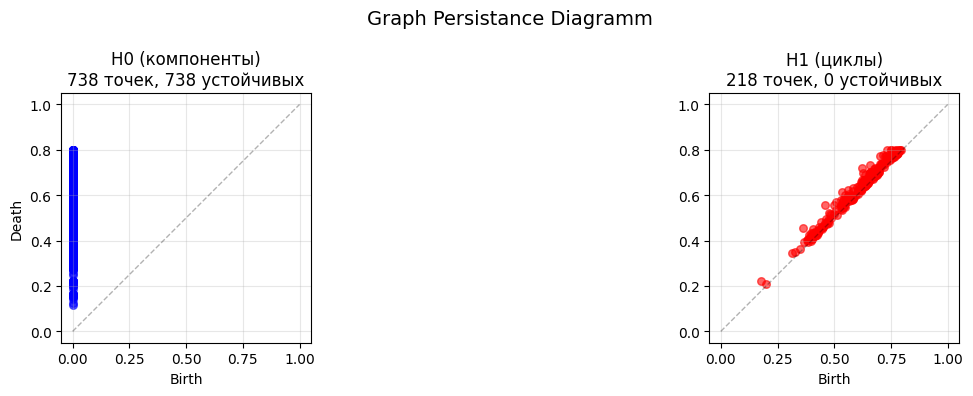


2. TDA на эмбеддингах (семантическая топология):
  H0: 619, H1: 73
  Среднее время жизни циклов: 0.2687
  Максимальное время жизни: 0.5040


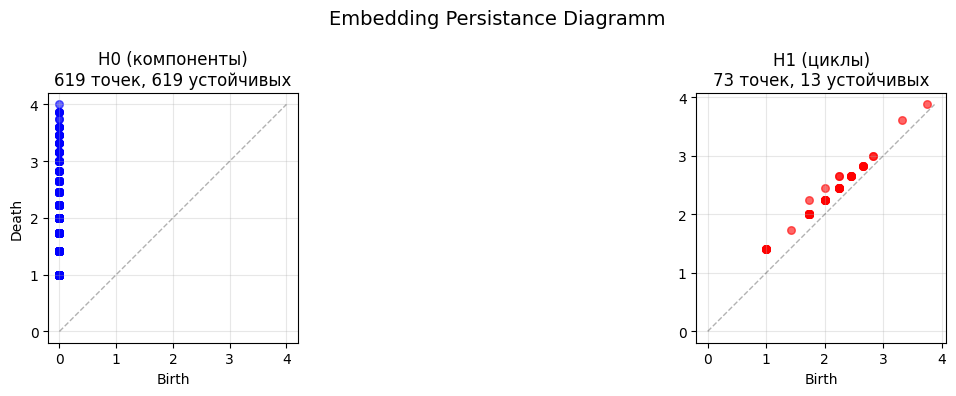


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 738
    dim0_mean_lifetime: 0.5394868850518505
    betti_1: 218
    dim1_mean_lifetime: 0.022381155487708655
    h1_persistent_above_0.2: 0
    clustering: 0.540621197635205
    assortativity: -0.06579494461431706
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 619
    dim0_mean_lifetime: 1.987936637012829
    betti_1: 73
    dim1_mean_lifetime: 0.2686764195020763
    h1_persistent_above_0.2: 58

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.777
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.075
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


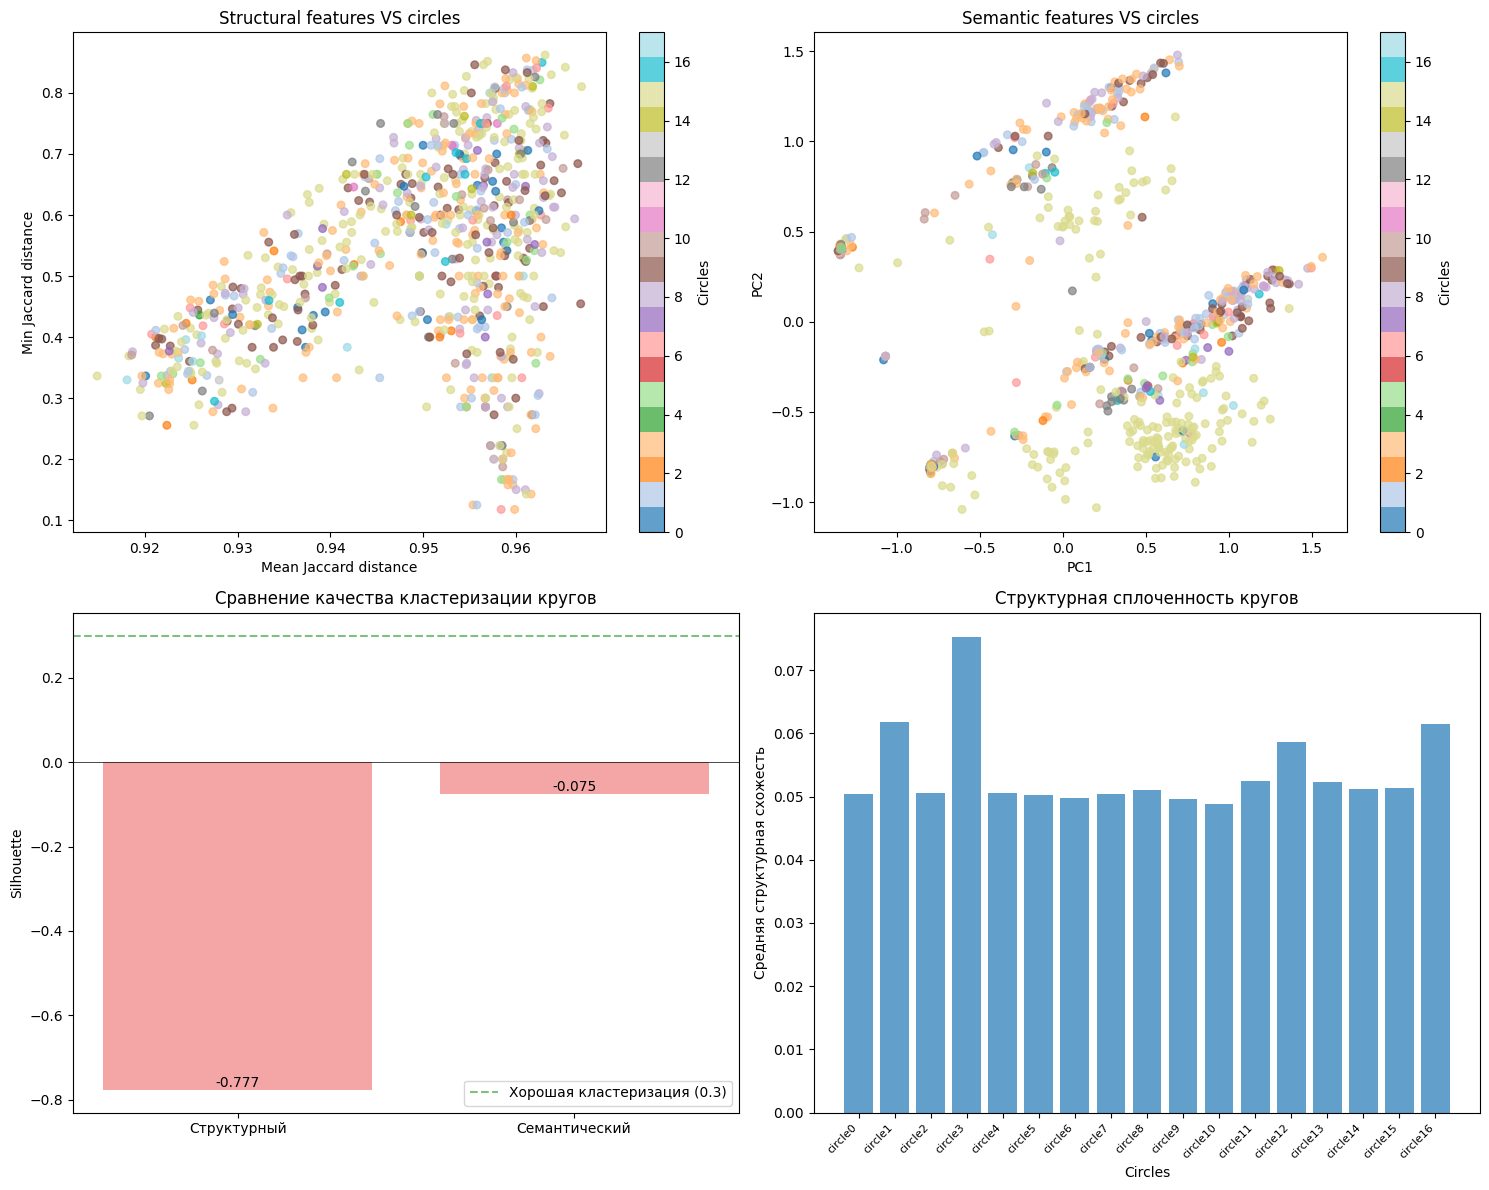

TDA analysis for ego-network 1912

1. TDA на графе (структурная топология):
  H0: 739, H1: 184
  Среднее время жизни: 0.0203
  Максимальное время жизни: 0.0857


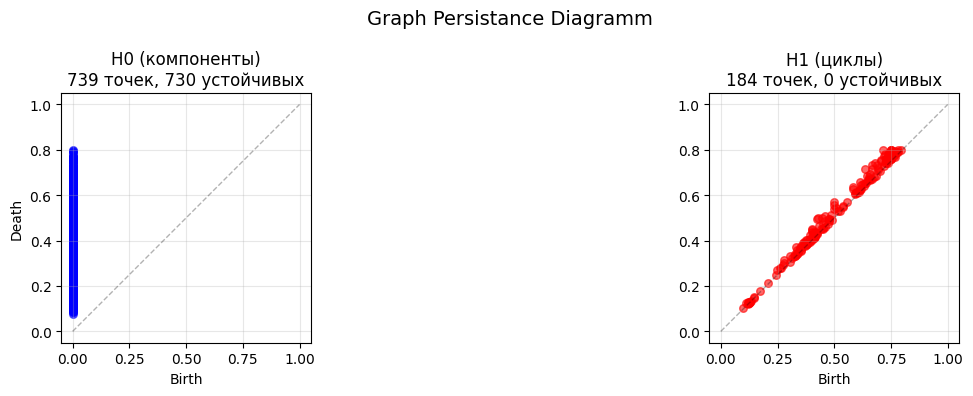


2. TDA на эмбеддингах (семантическая топология):
  H0: 666, H1: 73
  Среднее время жизни циклов: 0.2430
  Максимальное время жизни: 0.5040


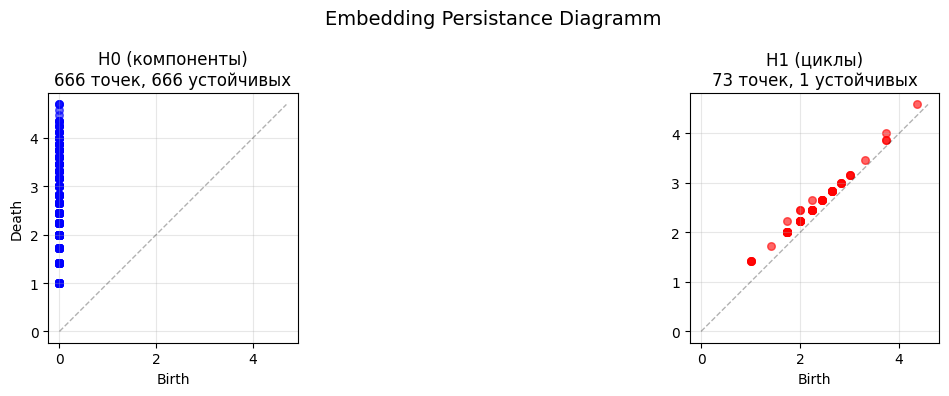


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 739
    dim0_mean_lifetime: 0.4084458930557854
    betti_1: 184
    dim1_mean_lifetime: 0.020310448359386
    h1_persistent_above_0.2: 0
    clustering: 0.6694806476969463
    assortativity: 0.10243200395008055
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 666
    dim0_mean_lifetime: 2.442460414998725
    betti_1: 73
    dim1_mean_lifetime: 0.2429851405499273
    h1_persistent_above_0.2: 48

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.871
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.100
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


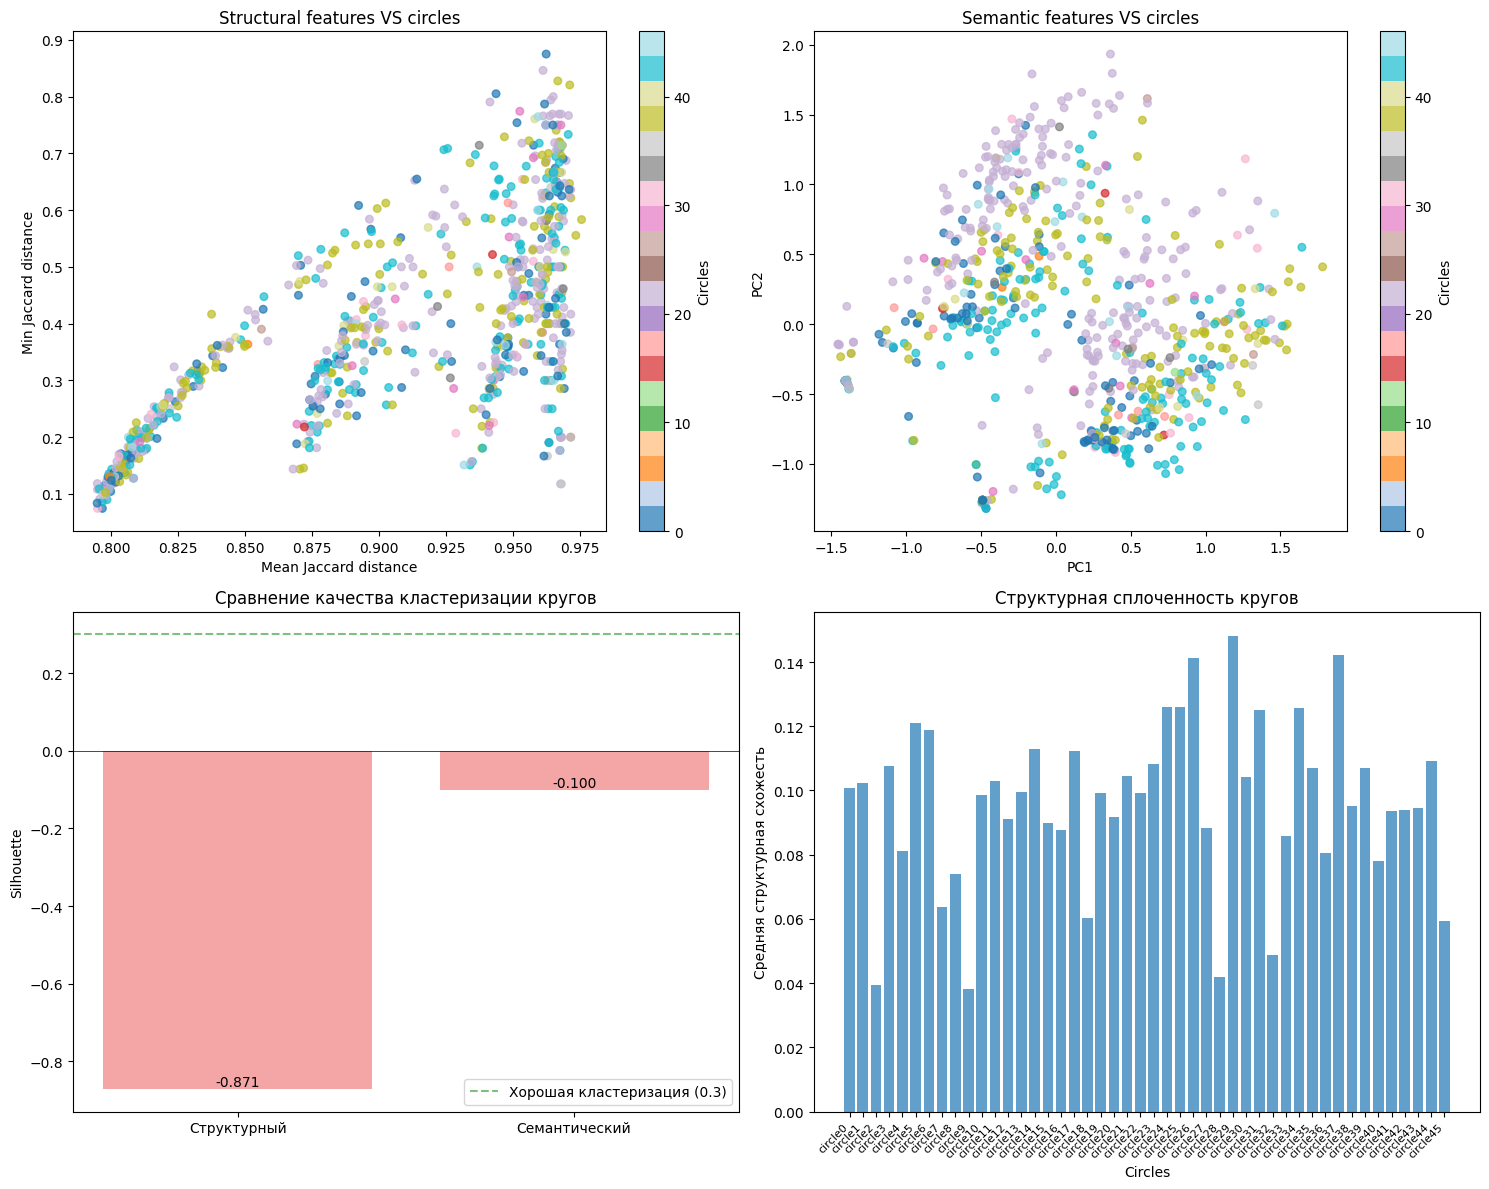

TDA analysis for ego-network 3437

1. TDA на графе (структурная топология):
  H0: 526, H1: 146
  Среднее время жизни: 0.0317
  Максимальное время жизни: 0.1494


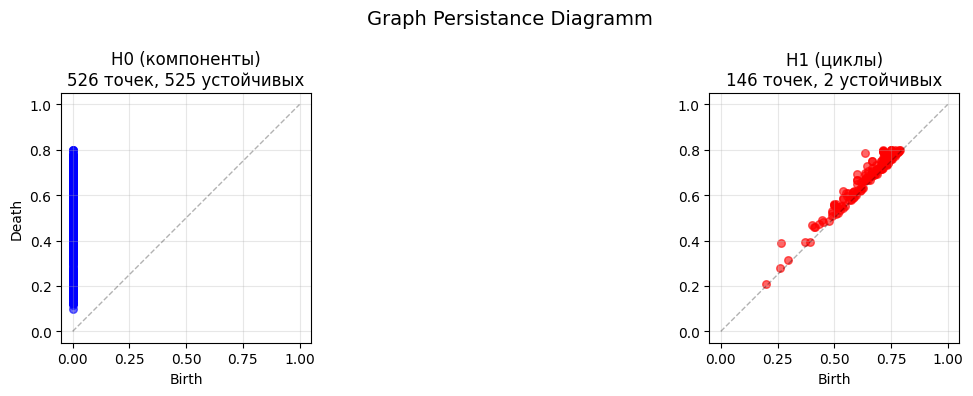


2. TDA на эмбеддингах (семантическая топология):
  H0: 401, H1: 43
  Среднее время жизни циклов: 0.2613
  Максимальное время жизни: 0.4495


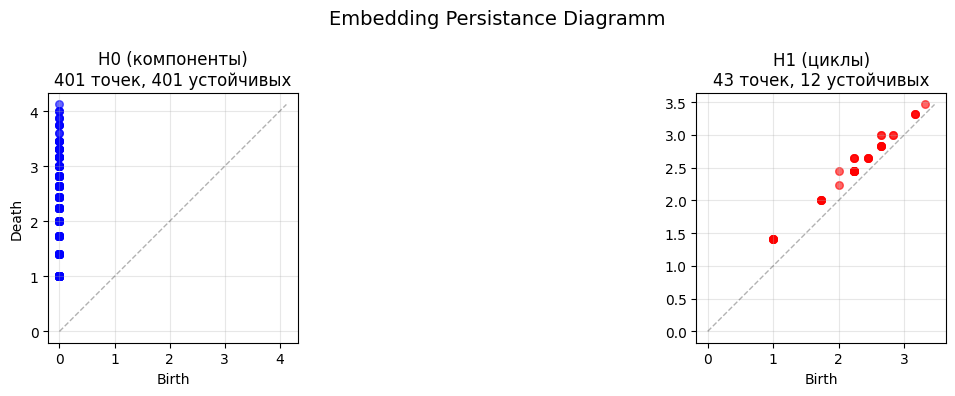


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 526
    dim0_mean_lifetime: 0.5066330010521511
    betti_1: 146
    dim1_mean_lifetime: 0.03167637990146556
    h1_persistent_above_0.2: 0
    clustering: 0.6388072137858635
    assortativity: -0.09086539663576841
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 401
    dim0_mean_lifetime: 2.1618126291653925
    betti_1: 43
    dim1_mean_lifetime: 0.26126603245257995
    h1_persistent_above_0.2: 28

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.746
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.292
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


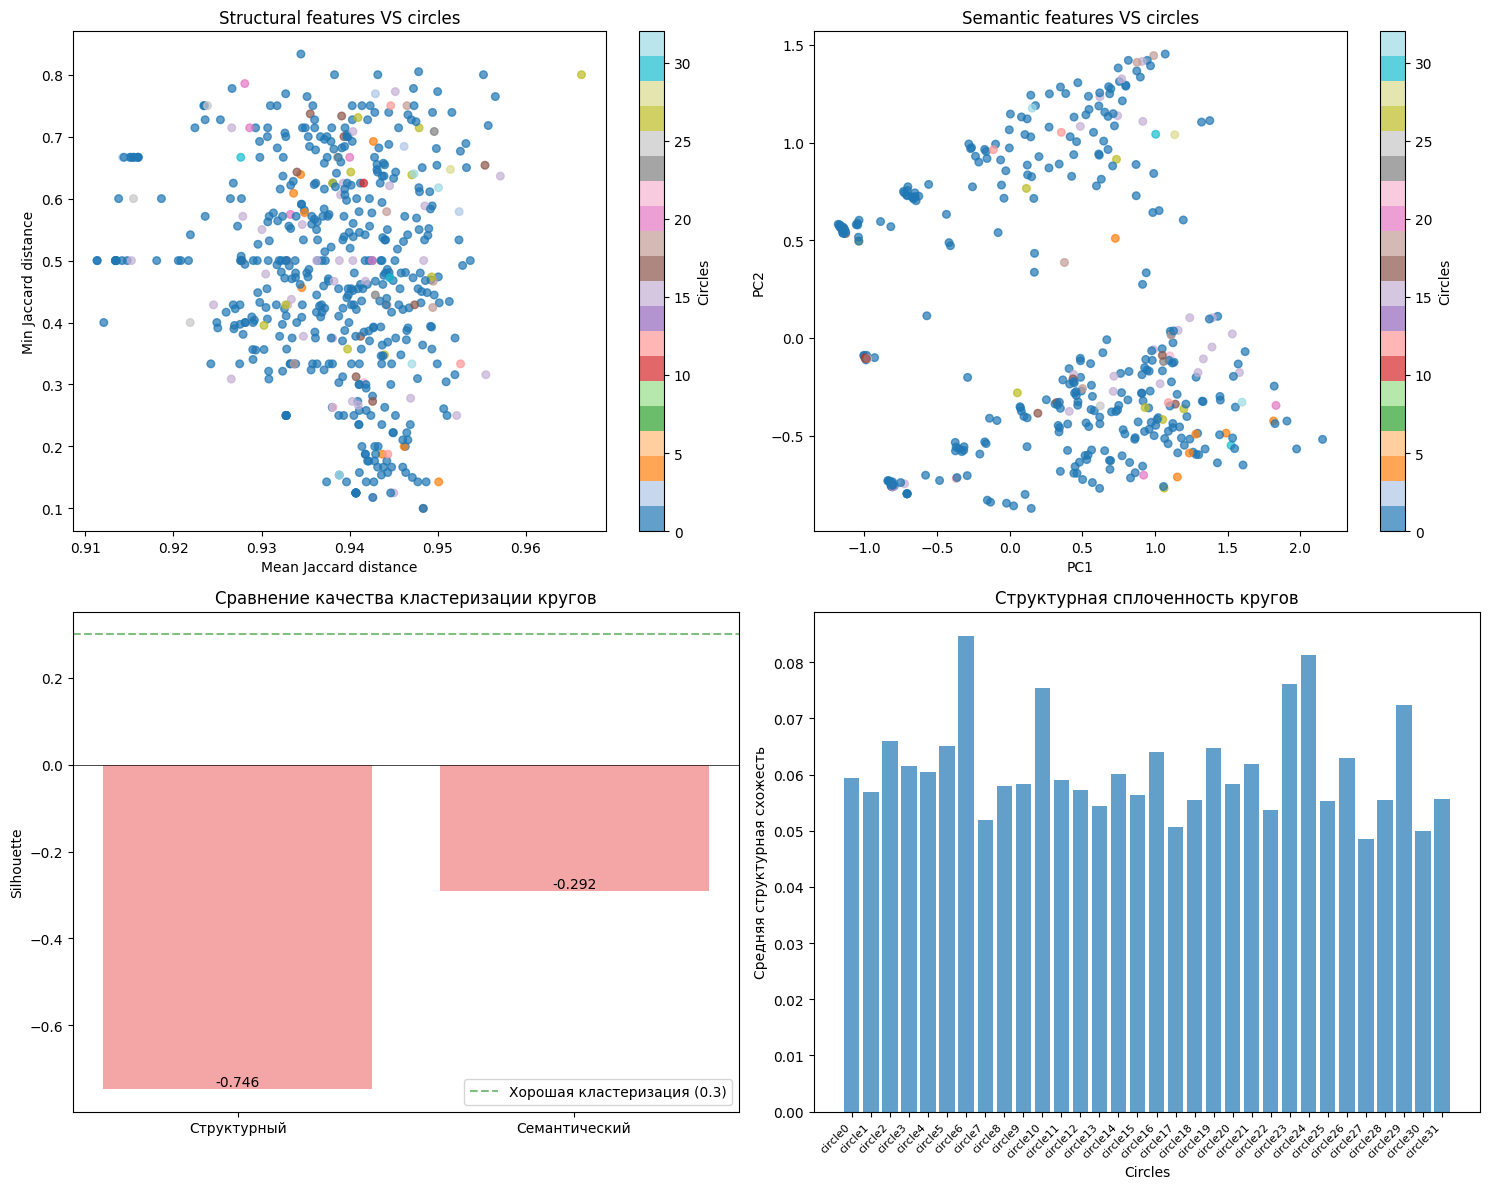

TDA analysis for ego-network 348

1. TDA на графе (структурная топология):
  H0: 220, H1: 76
  Среднее время жизни: 0.0272
  Максимальное время жизни: 0.0756


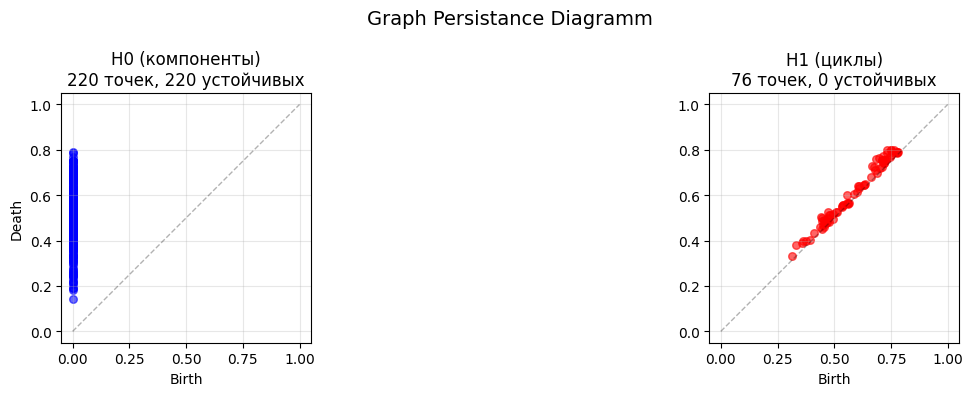


2. TDA на эмбеддингах (семантическая топология):
  H0: 210, H1: 25
  Среднее время жизни циклов: 0.1962
  Максимальное время жизни: 0.3339


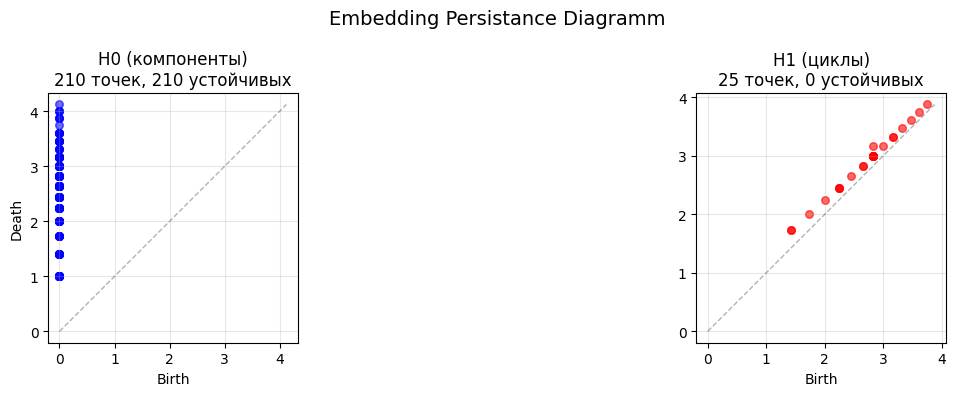


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 220
    dim0_mean_lifetime: 0.5075570408724632
    betti_1: 76
    dim1_mean_lifetime: 0.027249177647324117
    h1_persistent_above_0.2: 0
    clustering: 0.6244101587581964
    assortativity: -0.08627195864415525
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 210
    dim0_mean_lifetime: 2.5016617252229114
    betti_1: 25
    dim1_mean_lifetime: 0.19615045161642186
    h1_persistent_above_0.2: 8

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.405
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.082
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


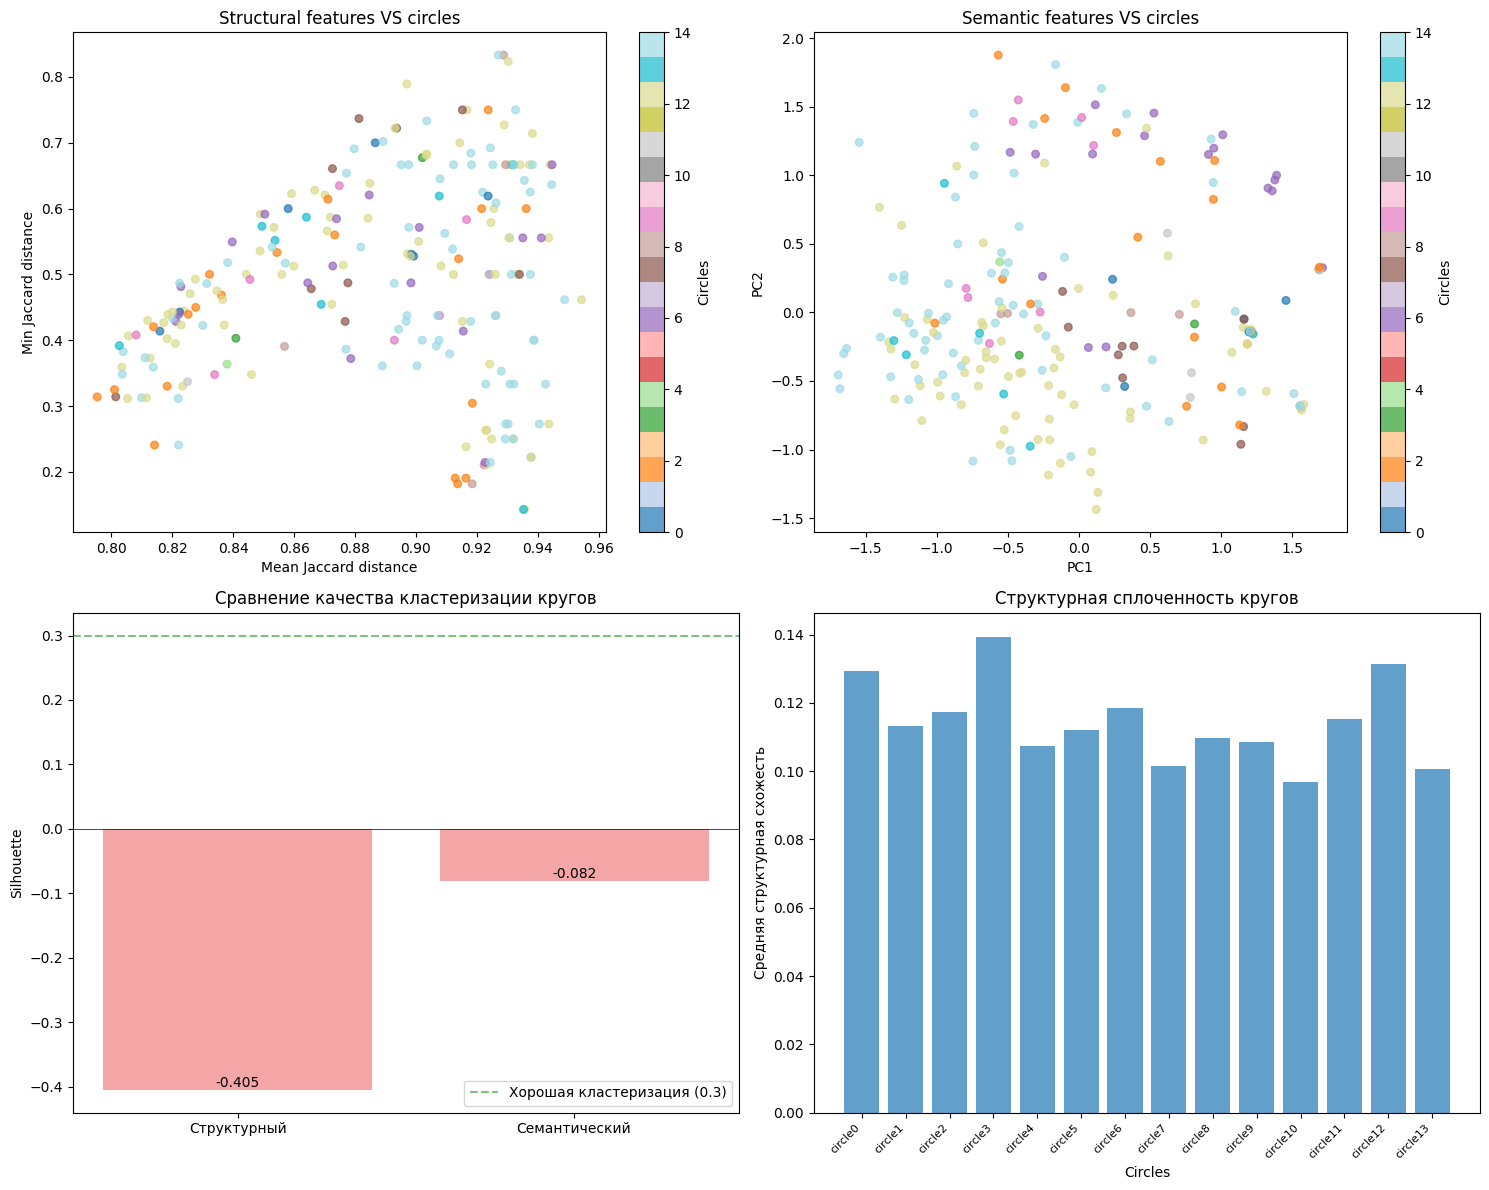

TDA analysis for ego-network 3980

1. TDA на графе (структурная топология):
  H0: 51, H1: 15
  Среднее время жизни: 0.0552
  Максимальное время жизни: 0.1692


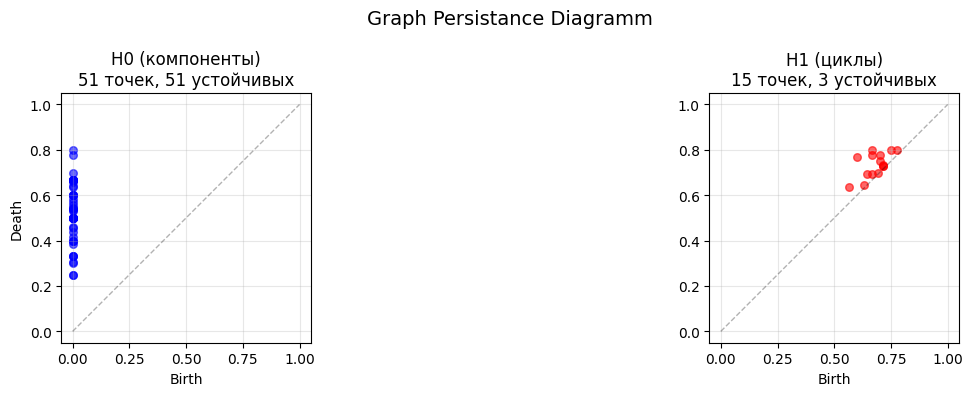


2. TDA на эмбеддингах (семантическая топология):
  H0: 40, H1: 8
  Среднее время жизни циклов: 0.2317
  Максимальное время жизни: 0.4097


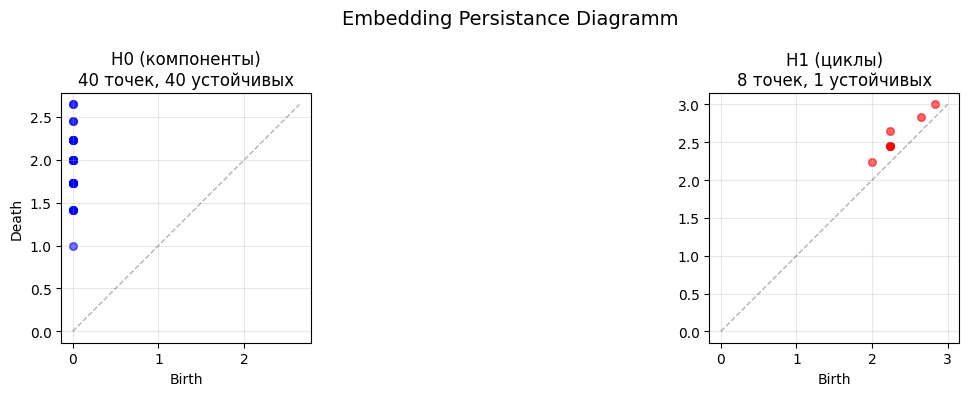


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 51
    dim0_mean_lifetime: 0.525798053168785
    betti_1: 15
    dim1_mean_lifetime: 0.05520712418006804
    h1_persistent_above_0.2: 0
    clustering: 0.7427558246998635
    assortativity: -0.2567380880339869
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 40
    dim0_mean_lifetime: 1.92416461613293
    betti_1: 8
    dim1_mean_lifetime: 0.23171088264169404
    h1_persistent_above_0.2: 6

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.771
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.170
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


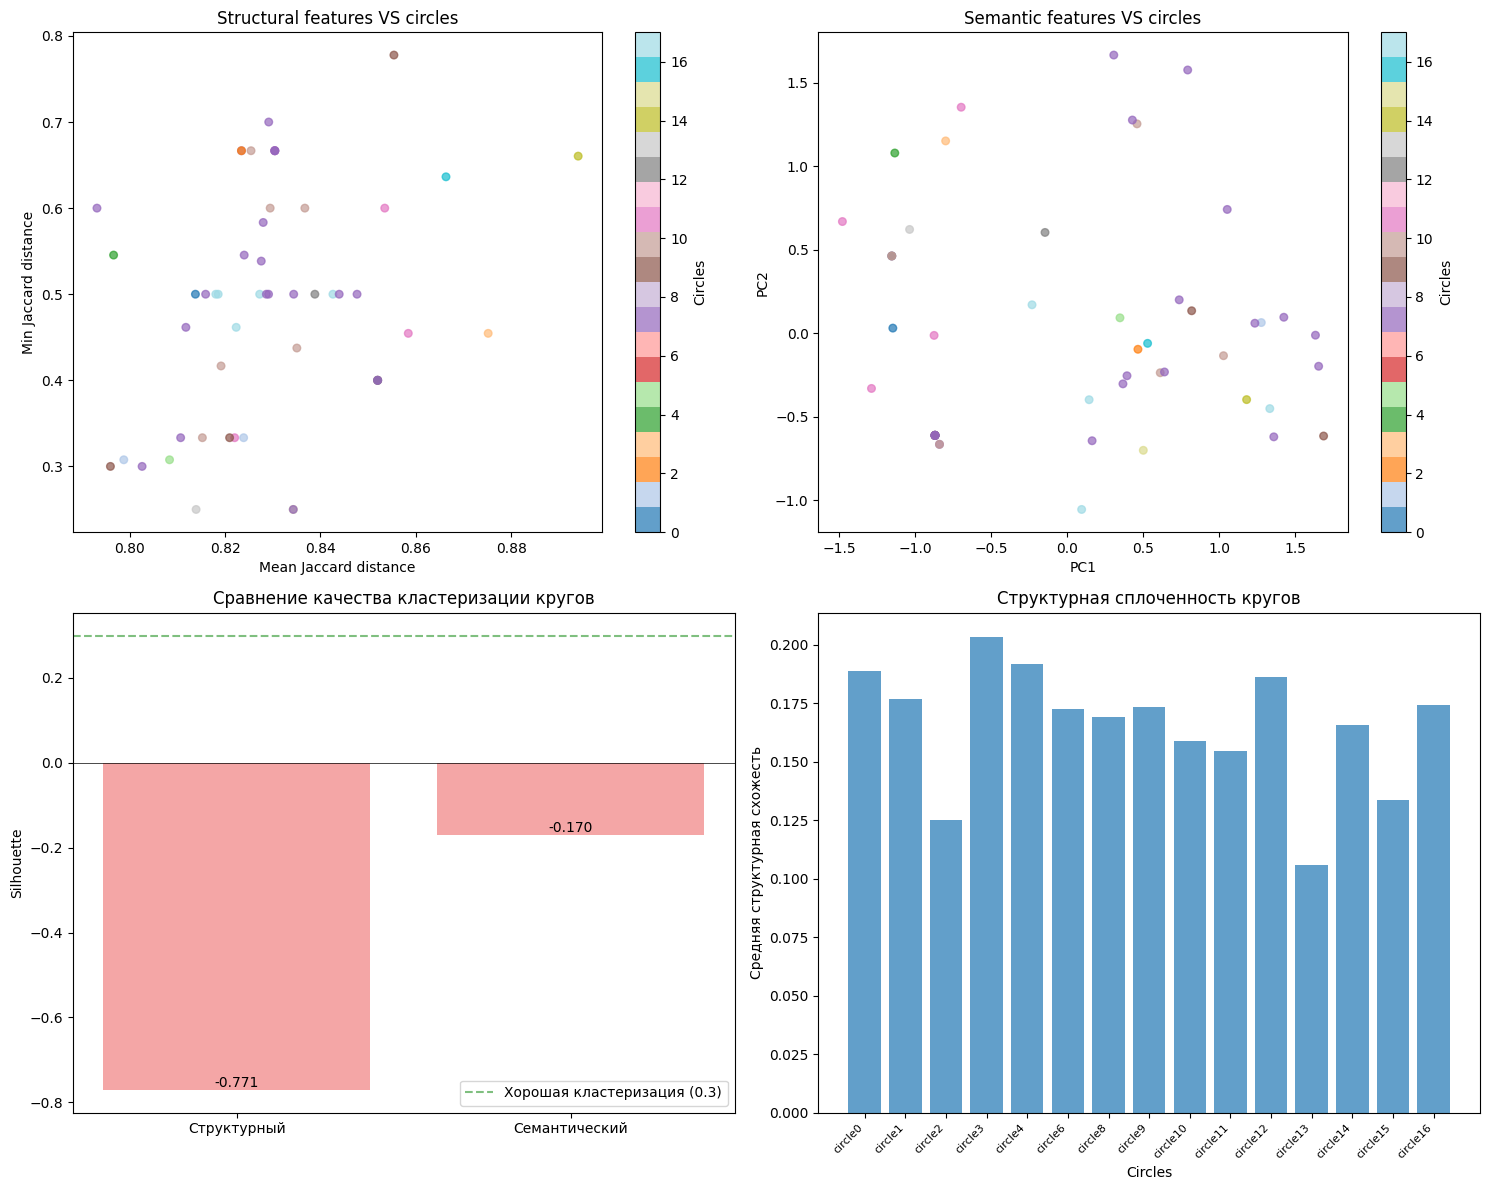

TDA analysis for ego-network 414

1. TDA на графе (структурная топология):
  H0: 148, H1: 52
  Среднее время жизни: 0.0281
  Максимальное время жизни: 0.1136


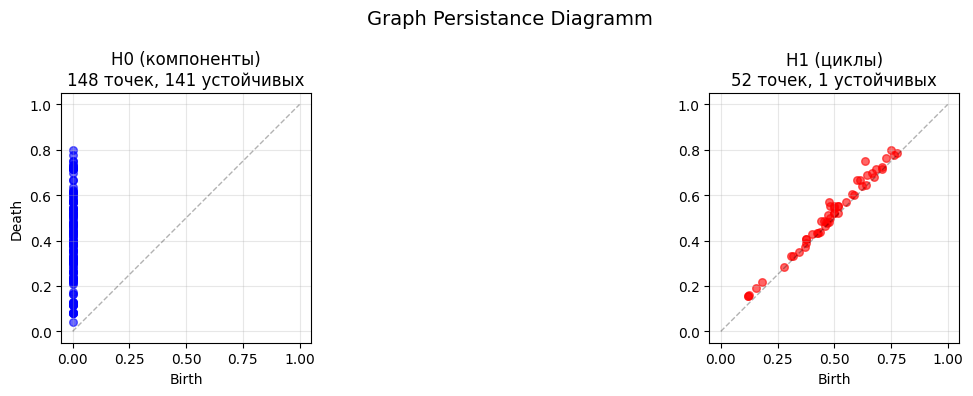


2. TDA на эмбеддингах (семантическая топология):
  H0: 142, H1: 27
  Среднее время жизни циклов: 0.2018
  Максимальное время жизни: 0.3789


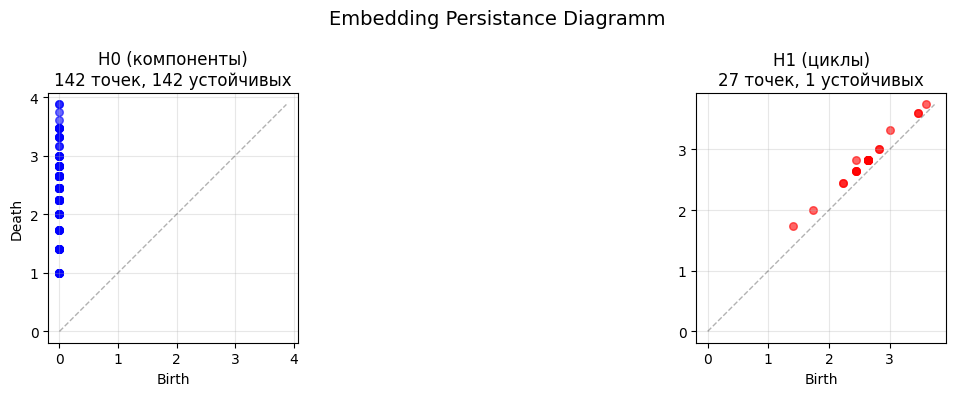


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 148
    dim0_mean_lifetime: 0.40604473940440666
    betti_1: 52
    dim1_mean_lifetime: 0.028149183162688586
    h1_persistent_above_0.2: 0
    clustering: 0.7272371269176219
    assortativity: -0.07849460545396367
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 142
    dim0_mean_lifetime: 2.4097043485665792
    betti_1: 27
    dim1_mean_lifetime: 0.20175923556618447
    h1_persistent_above_0.2: 6

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.276
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.098
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


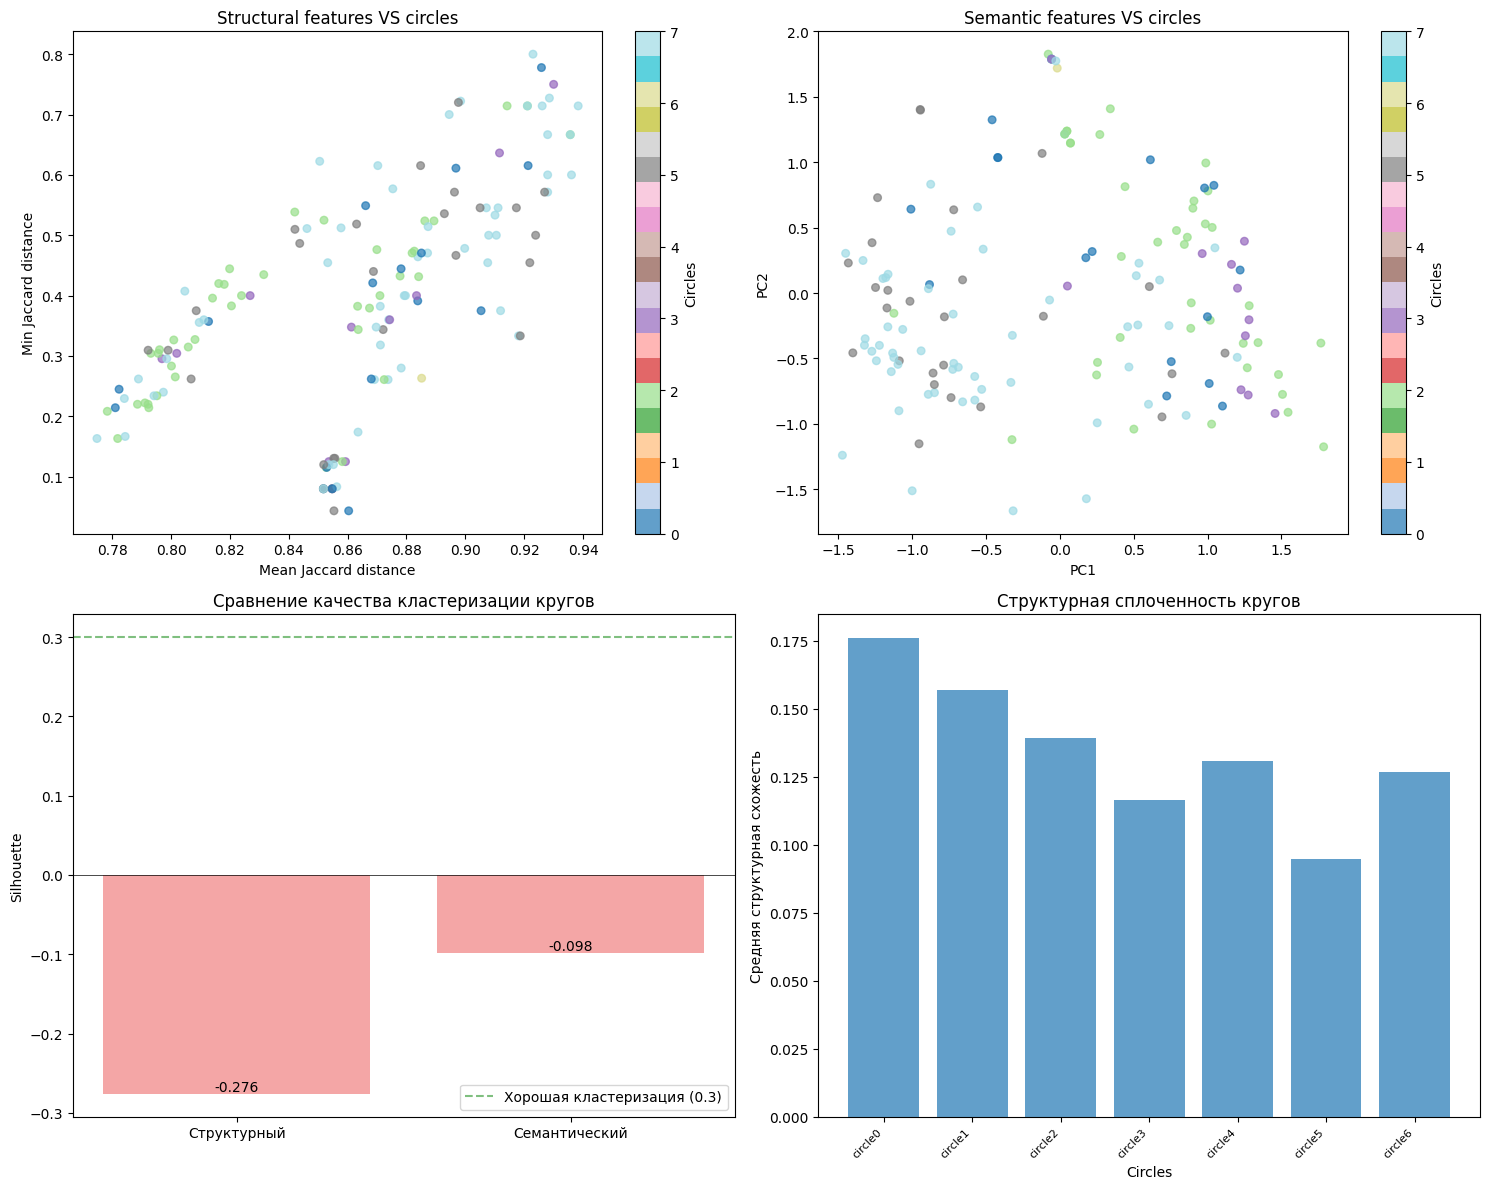

TDA analysis for ego-network 686

1. TDA на графе (структурная топология):
  H0: 167, H1: 71
  Среднее время жизни: 0.0343
  Максимальное время жизни: 0.0895


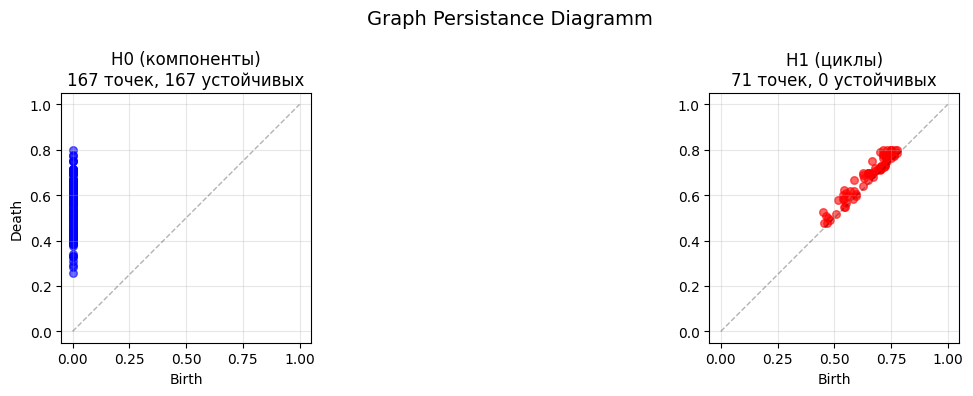


2. TDA на эмбеддингах (семантическая топология):
  H0: 134, H1: 30
  Среднее время жизни циклов: 0.2779
  Максимальное время жизни: 0.5040


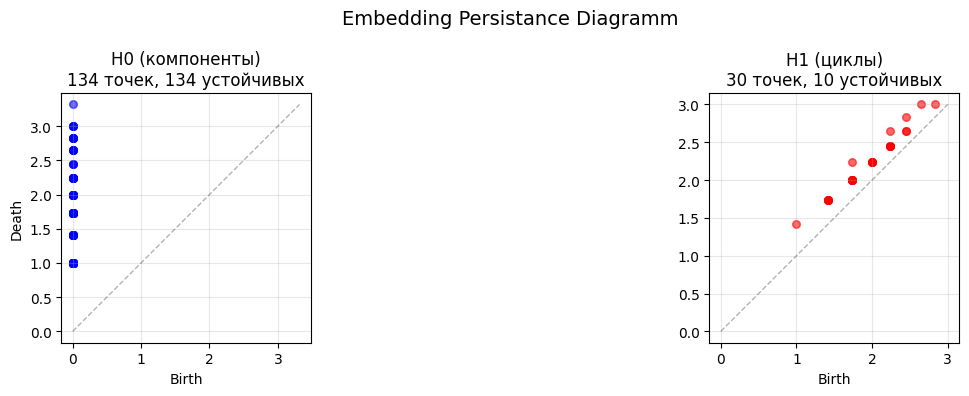


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 167
    dim0_mean_lifetime: 0.5389761133565688
    betti_1: 71
    dim1_mean_lifetime: 0.03434148374564464
    h1_persistent_above_0.2: 0
    clustering: 0.6303995866227038
    assortativity: -0.14642203553434313
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 134
    dim0_mean_lifetime: 1.709676048988442
    betti_1: 30
    dim1_mean_lifetime: 0.27791584784988427
    h1_persistent_above_0.2: 27

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.808
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.097
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


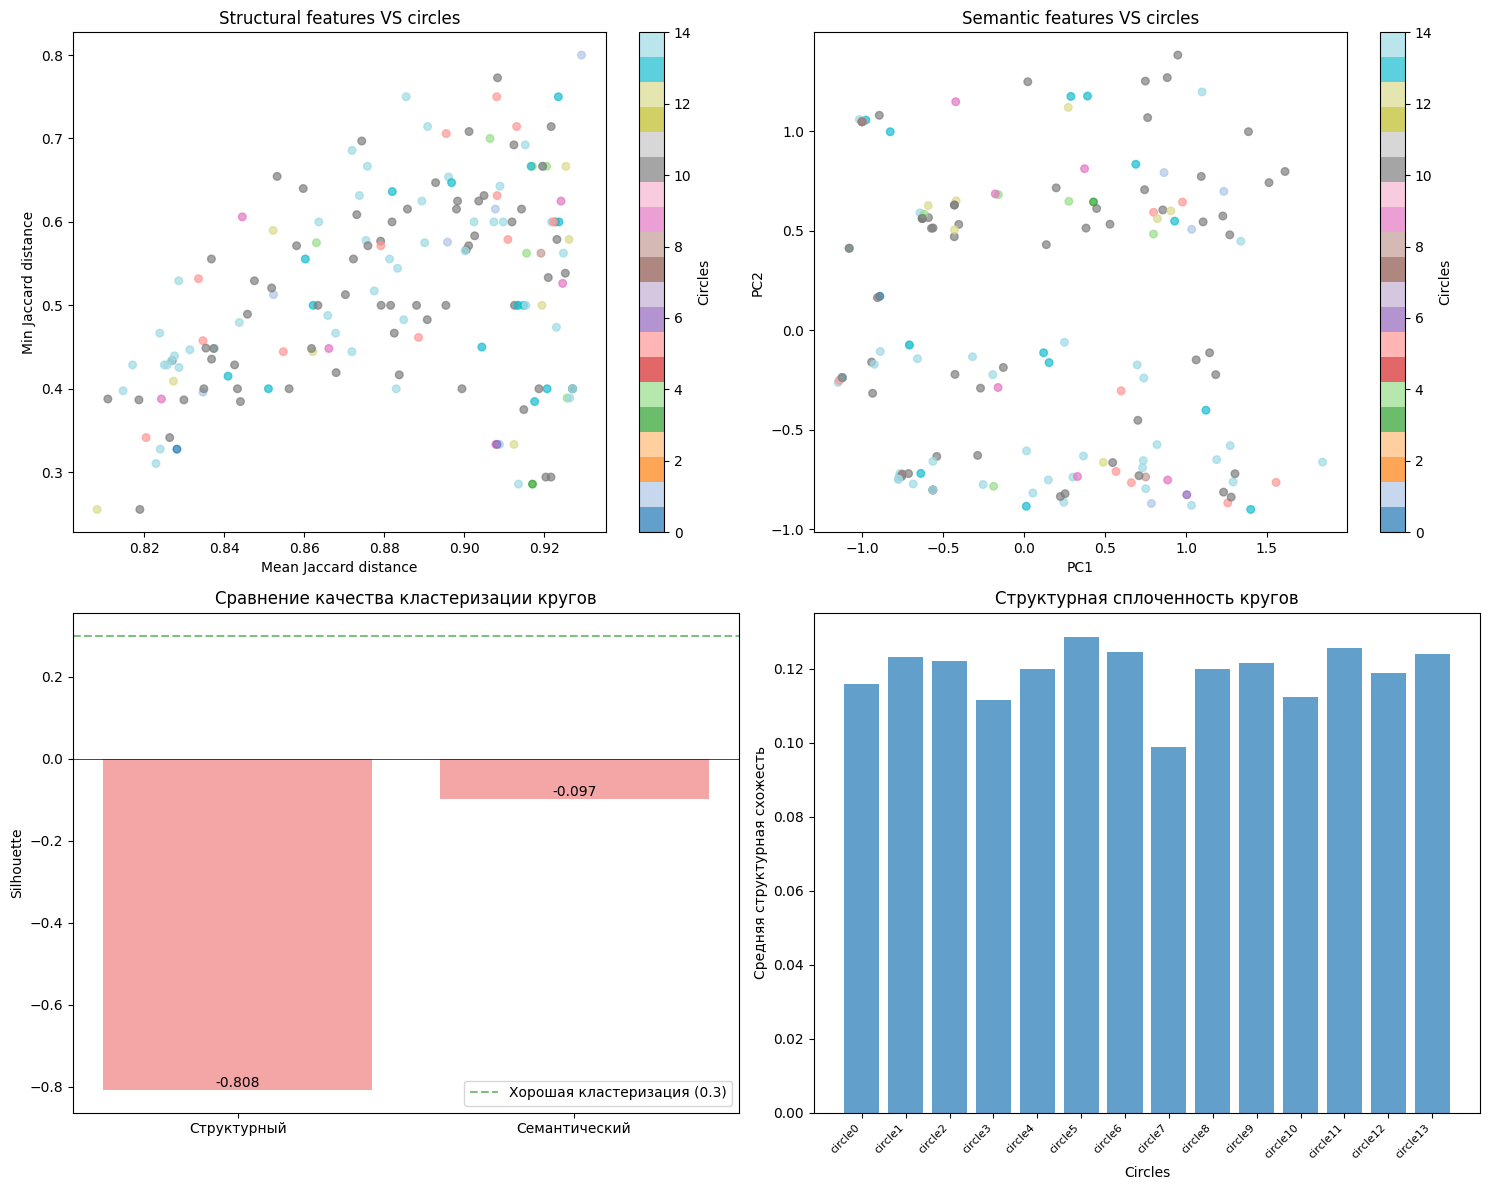

TDA analysis for ego-network 698

1. TDA на графе (структурная топология):
  H0: 60, H1: 9
  Среднее время жизни: 0.0271
  Максимальное время жизни: 0.0546


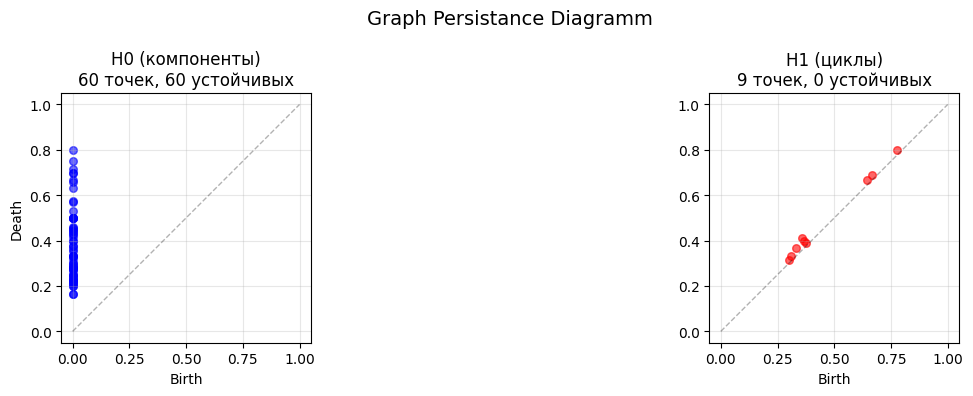


2. TDA на эмбеддингах (семантическая топология):
  H0: 45, H1: 8
  Среднее время жизни циклов: 0.2814
  Максимальное время жизни: 0.4142


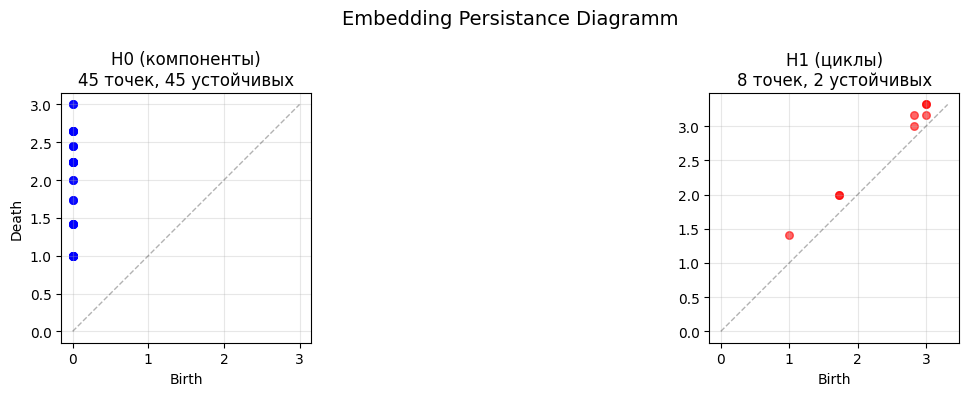


3. Извлечение топо-фичей:

4. Извлечение топологических инвариантов:
  Инварианты графа:
    betti_0: 60
    dim0_mean_lifetime: 0.3893487561902197
    betti_1: 9
    dim1_mean_lifetime: 0.027052553665040766
    h1_persistent_above_0.2: 0
    clustering: 0.8112772100244874
    assortativity: -0.16582784816935653
    diameter: 2
  Инварианты эмбеддингов:
    betti_0: 45
    dim0_mean_lifetime: 1.963562927122843
    betti_1: 8
    dim1_mean_lifetime: 0.2813828248488148
    h1_persistent_above_0.2: 6

5. Сравнение с пользовательскими кругами:

  5.1. Структурная топология vs круги:
    Силуэтный коэффициент (структурный): -0.677
    Круги НЕ соответствуют структурным сообществам

  5.2. Семантическая топология vs круги:
    Силуэтный коэффициент (семантический): -0.201
    Круги НЕ соответствуют семантическим кластерам

  5.3. Визуализация сравнений:


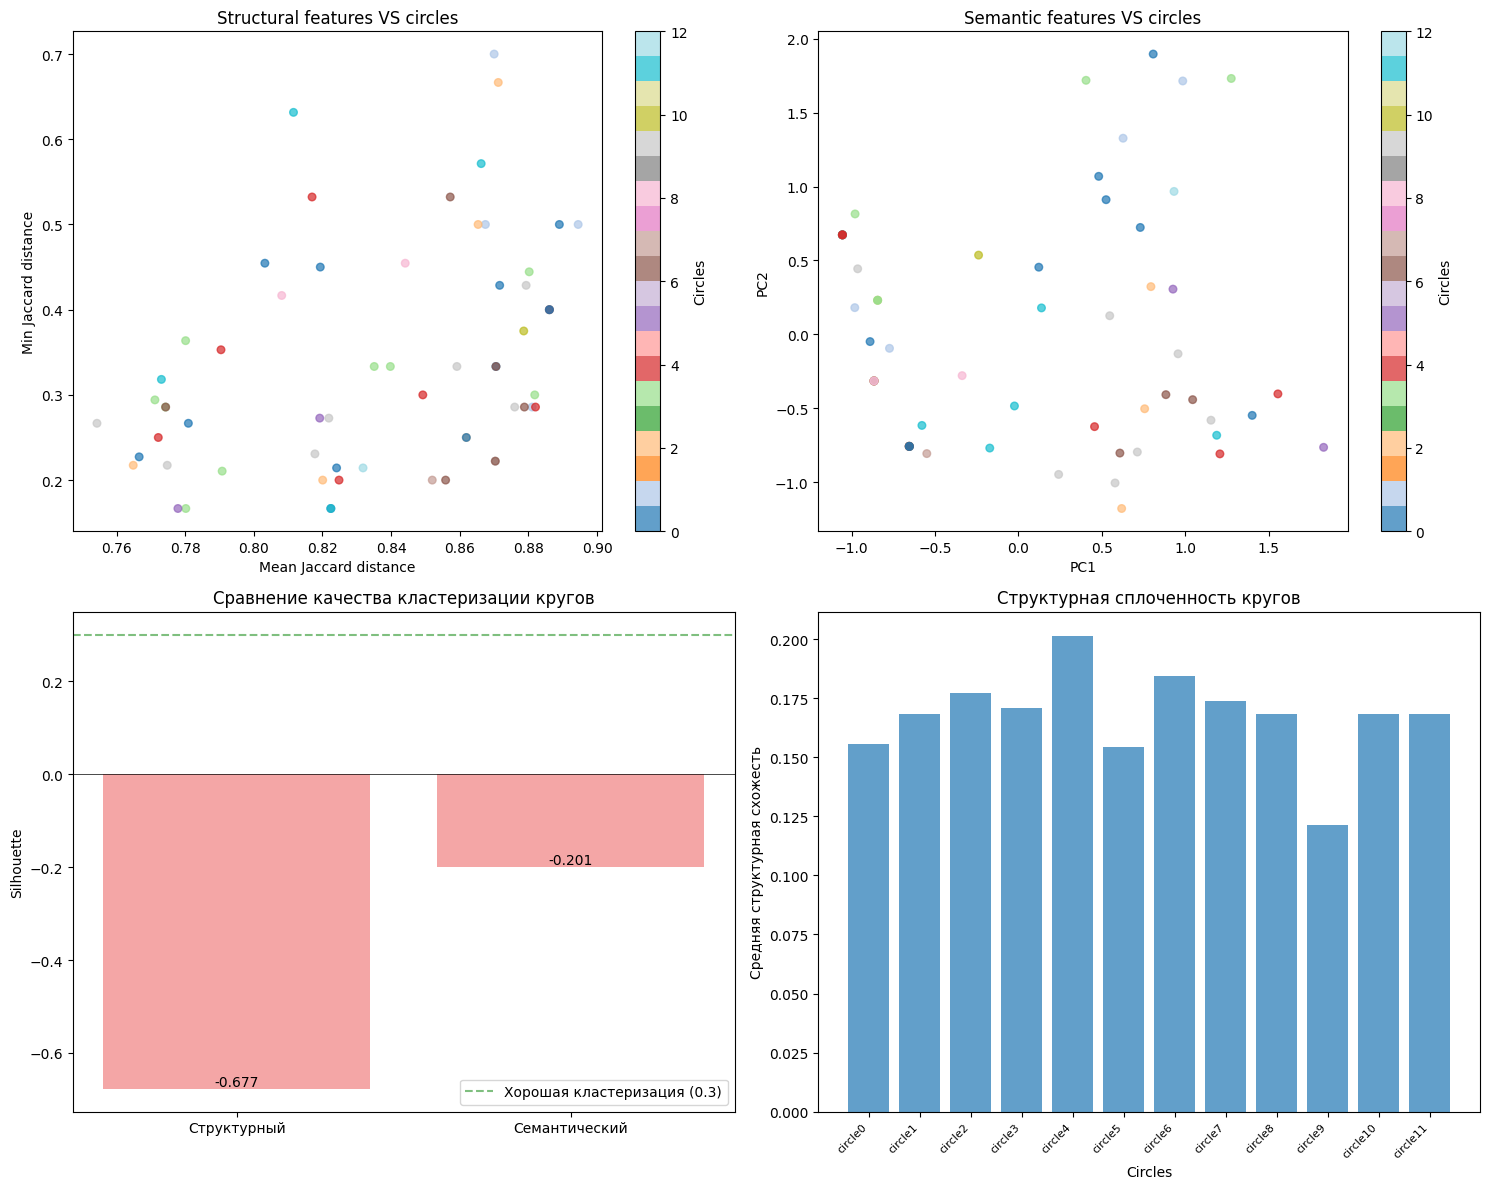

In [16]:
tda_results_dict = {}
for ego_id in ego_networks.keys():
    tda_results_dict[ego_id] = tda_pipeline(ego_networks[ego_id], ego_id)


## Результаты TDA для ego-network:
1. Вместо исходной гипотезы "пользовательские круги соответствуют геометрическим\семантическим кластерам" получилось ровно наоборот - ни в одной из ego-network круги не соответствуют ни семантическим, ни структурным кластерам. Результат основан на силуэтном коэффициенте, который не превысил -0.02 (это был самый максимальный результат) - т.е. узлы внутри одного круга в среднем больше похожи на узлы из других, чем на свои
2. Пользователи размечают круги по разным критериям, участники которых, зачастую, вообще не похожи между собой (например "коллеги", "соседи", "школьные знакомые" и пр). Их объединяет география, время, эмоции, интересы, а не наличие связей с остальными участниками ego-network, что выражено в низком времени жизни структурных циклов H1
3. Время жизни семантических циклов H1 всегда больше структурных, что подтверждает гипотезу об объединении пользовательских кругов по принципу эмоций или интересов - такие циклы являются более значимыми топологическими фичами
4. Поскольку количество семантических циклов всегда меньше структурых, это говорит о том, что его друзья, будучи сильно связаны структурно, образуют несколько более чётких и устойчивых семантических групп. Возможно, эти семантические кластеры могли бы стать более естественным разделением ego-network на круги, чем те, которые пользователь задал сам.
5. Низкая структурная сплочённость внутри кругов - в среднем 10% (последний график), говорящая о том, насколько пользователи из круга похожи в социальном смысле. Фактически если у ego 100 друзей, то с другими членами из круга у него в среднем всего 10 общих друзей. Это также согласуется с низким силуэтным коэффициентом и подтверждает вывод, что **пользовательские круги — субъективные социальные группы**

|Prior|Гипотеза|Метрика|Результат|Вывод|
|:-|:-:|--|--|--|
|**Гомофилия**|Узлы внутри одного пользовательского круга семантически/структурно похожи.|Силуэтный коэффициент кластеризации по кругам в пространстве эмбеддингов/расстояний Жаккара.| не превысил -0.02|**Не подтверждёно** для размеченных пользователями кругов. Круги субъективны и не соответствуют кластерам в данных.|
|**Транзитивность**|Граф содержит множество "социальных треугольников".|Коэффициент кластеризации + наличие циклов H1 в персистентной диаграмме.|H1 есть, но время жизни невелико. Коэффициент кластеризации около 0.6|**Частично подтверждёно**. Структурные циклы существуют, но нестабильны.|
|**Ассортативность по степени**|Связанные узлы имеют схожую степень.|Коэффициент ассортативности графа ego-network.| Отрицательный (кроме ego 1912)|**Не подтверждёно**. Наблюдается анти-ассортативность, хотя это и согласуется с концепцией ego-network|


## 2.2. Глобальный TDA

### Функции для работы

In [17]:
def node_sampling(G,  sample_size=1200, random_state=42):   
    nodes = list(G.nodes())    
    np.random.seed(random_state)
    sampled_nodes = np.random.choice(nodes, min(sample_size, len(nodes)), replace=False)
    
    print(f"  Выбрано {len(sampled_nodes)} узлов")
    print(f"  Средняя степень в выборке: {np.mean([G.degree(n) for n in sampled_nodes]):.1f}")
    
    return list(sampled_nodes)


In [18]:
def compute_distance_matrix_for_sample(G, sampled_nodes):

    print(f"\nВычисление матрицы расстояний для выборки")
    
    start_time = time.time()
    n = len(sampled_nodes)
    dist_matrix = np.zeros((n, n))  

    neighbors_dict = {}
    for i, node in enumerate(sampled_nodes):
        neighbors_dict[i] = set(G.neighbors(node))

    for i in range(n):
        if i % 50 == 0 and i > 0:
            elapsed = time.time() - start_time
            remaining = (elapsed / (i+1)) * (n - i)
        
        neighbors_i = neighbors_dict[i]
        
        for j in range(i+1, n):
            neighbors_j = neighbors_dict[j]
            
            if neighbors_i or neighbors_j:
                intersection = len(neighbors_i & neighbors_j)
                union = len(neighbors_i | neighbors_j)
                similarity = intersection / union if union > 0 else 0
                distance = 1 - similarity
            else:
                distance = 1.0
            
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    
    elapsed_time = time.time() - start_time
    print(f"  Время вычисления: {elapsed_time:.2f} секунд")
    
    return dist_matrix

In [19]:
def compute_global_features_full_graph(G):
    
    features = {}    
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    features['density'] = nx.density(G)
    features['avg_clustering'] = nx.average_clustering(G)
    
    # ассортативность
    features['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
    
    # степени
    degrees = [d for _, d in G.degree()]
    features['degree_mean'] = np.mean(degrees)
    features['degree_std'] = np.std(degrees)
    features['degree_max'] = np.max(degrees)    

    # PageRank 
    features['pagerank'] = nx.pagerank(G, alpha=0.85)
    
    # betweenness 
    k = min(1000, G.number_of_nodes())
    features['betweenness'] = nx.betweenness_centrality(G, k=k)
    
    # центральнность по степени
    features['degree_centrality'] = nx.degree_centrality(G)
    
    # cообщества по Лувену
    partition = community_louvain.best_partition(G)
    features['communities'] = partition
    features['num_communities'] = len(set(partition.values()))
    
    comm_sizes = {}
    for node, comm_id in partition.items():
        comm_sizes[comm_id] = comm_sizes.get(comm_id, 0) + 1
    features['avg_community_size'] = np.mean(list(comm_sizes.values()))     
    
    # связность
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        features['diameter'] = None
        features['avg_path_length'] = None
    
    return features

In [20]:
def visualize_full_tda(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    ax = axes[0]
    colors = ['blue', 'red', 'green']
    for dim in [0, 1]:
        if dim in persistence_by_dim and persistence_by_dim[dim]:
            points = persistence_by_dim[dim]
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            ax.scatter(births, deaths, alpha=0.6, s=20, color=colors[dim], label=f'H{dim}')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title('Персистентные диаграммы (выборка)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    pagerank_values = [global_features['pagerank'][node] for node in sampled_nodes]
    ax.hist(pagerank_values, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('PageRank')
    ax.set_ylabel('Частота')
    ax.set_title('Распределение PageRank в выборке')
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    degrees = [G.degree(node) for node in sampled_nodes]
    clusterings = [nx.clustering(G, node) for node in sampled_nodes]
    
    scatter = ax.scatter(degrees, clusterings, alpha=0.5, s=20, 
                        c=[global_features['pagerank'][node] for node in sampled_nodes],
                        cmap='viridis')
    ax.set_xlabel('Степень узла')
    ax.set_ylabel('Коэффициент кластеризации')
    ax.set_title('Степень vs Кластеризация (цвет = PageRank)')
    plt.colorbar(scatter, ax=ax, label='PageRank')
    ax.grid(True, alpha=0.3)   

    
    plt.suptitle(f'Результаты TDA на графе\nВыборка: {len(sampled_nodes)} узлов из {G.number_of_nodes()}')
    plt.tight_layout()
    plt.show()

### TDA pipeline

In [24]:
def tda_on_sample(G, sample_size=1000):

    print("\n" + "="*70)
    print("TDA графа")
    print("="*70)
    
    sampled_nodes = node_sampling(G, sample_size)
    
    print("\n1. TDA на выборке узлов:")
    dist_matrix = compute_distance_matrix_for_sample(G, sampled_nodes)
    
    # Построение VR-комплекса
    print("\n2. Построение VR-комплекса:")
    non_zero_dists = dist_matrix[dist_matrix > 0]
    if len(non_zero_dists) > 0:
        max_edge = np.percentile(non_zero_dists, 85)
    else:
        max_edge = 0.8
    
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.001)
    
    # Анализ персистентных гомологий
    persistence_by_dim = {}
    for dim in range(3):
        points = [(birth, death) for (d, (birth, death)) in persistence if d == dim and death != float('inf')]
        persistence_by_dim[dim] = points
        
        if points:
            lifetimes = [death - birth for birth, death in points]
            print(f"  H{dim}: {len(points)} точек")
            print(f"    Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"    Максимальное время жизни: {np.max(lifetimes):.4f}")
    
    print("\n3. Вычисление глобальных фичей:")
    global_features = compute_global_features_full_graph(G)

    sampled_node_ids = sampled_nodes

    enriched_features = {}
    for i, node_id in enumerate(sampled_node_ids):
        features = {
            'jaccard_avg_distance': np.mean(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_min_distance': np.min(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_std_distance': np.std(dist_matrix[i, dist_matrix[i] > 0]),
            
            'global_pagerank': global_features['pagerank'][node_id],
            'global_betweenness': global_features['betweenness'][node_id],
            'global_degree_centrality': global_features['degree_centrality'][node_id],
            'global_degree': G.degree(node_id),
            'global_community_id': global_features['communities'][node_id],

            'local_clustering': nx.clustering(G, node_id),
        }
        
        neighbors = list(G.neighbors(node_id))
        if neighbors:
            neighbor_degrees = [G.degree(n) for n in neighbors]
            features['neighbor_degree_mean'] = np.mean(neighbor_degrees)
            features['neighbor_degree_std'] = np.std(neighbor_degrees)
        else:
            features['neighbor_degree_mean'] = 0
            features['neighbor_degree_std'] = 0
        
        enriched_features[node_id] = features

    print("\n4. Визуализация результатов:")
    visualize_full_tda(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features)
    
    return {
        'sampled_nodes': sampled_nodes,
        'distance_matrix': dist_matrix,
        'persistence_by_dim': persistence_by_dim,
        'global_features': global_features,
        'enriched_features': enriched_features,
        'graph': G
    }



TDA графа
  Выбрано 1500 узлов
  Средняя степень в выборке: 42.4

1. TDA на выборке узлов:

Вычисление матрицы расстояний для выборки
  Время вычисления: 3.38 секунд

2. Построение VR-комплекса:
  H0: 1476 точек
    Среднее время жизни: 0.5577
    Максимальное время жизни: 0.9167
  H1: 712 точек
    Среднее время жизни: 0.0269
    Максимальное время жизни: 0.1347

3. Вычисление глобальных фичей:

4. Визуализация результатов:


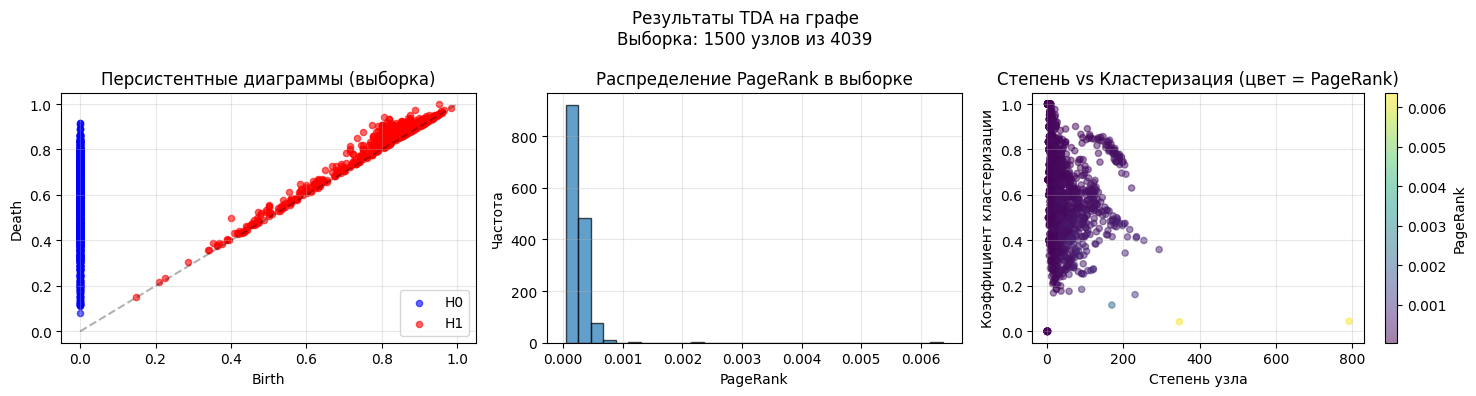

In [25]:
results = tda_on_sample(G_combined, sample_size=1500)

### Выводы о структуре графа Facebook из проведённого TDA на всём графе 
**1. Структурная связность по Жаккару**  
На выборке 1500 узлов обнаружено 1476 компонент связности H0 (98% от выборки). Следовательно, расстояние Жаккара создаёт почти полностью связную структуру на малых масштабах фильтрации. Это означает:
 - узлы уже при малых расстояниях оказываются структурно похожими по общим соседям;
 - сообщение может быстро распространяться по графу через общих друзей (message passing)

**2. Транзитивность и циклические структуры**
Обнаружено 712 циклов H1 (47.5% от выборки), но с коротким временем жизни (max=0.135, среднее=0.027). Данный факт подтверждает prior транзитивности (друг моего друга — мой друг), однако из-за короткого времени жизни эти циклы локальны и нестабильны, не образуют устойчивых кластеров.

**3. Ассортативность по степени: локальное vs глобальное**
Глобальная ассортативность = 0.064. Это в свою очередь демонстрирует зависимость от масштаба анализа - в ego-network почти везде наблюдалась анти-ассортативность, но глобально она слабо положительная => хабы предпочитают связываться с хабами, листья с листьями, однако тенденция слаба

**4. Prior'ы, выявленные при TDA ego-networks, не экстраполируются на полный граф**

## 3. Обогащение признаков для дальнейшего использования в GNN

In [26]:
def enrich_ego_networks(ego_networks, global_features, tda_results_dict):
    enriched_ego_networks = {}
    
    for ego_id, ego_data in ego_networks.items():
        G_ego = ego_data['graph']
                
        node_features_array = ego_data.get('node_features', None)
        node_ids_list = ego_data.get('node_ids', list(G_ego.nodes()))
        node_to_idx = {node: i for i, node in enumerate(node_ids_list)}

        # TDA-признаки 
        tda_features = tda_results_dict.get(ego_id, {})
        
        enriched_nodes = {}
        for node in G_ego.nodes():
            if node in global_features['pagerank']:
                features = {}
                                
                if node_features_array is not None and node in node_to_idx:
                    idx = node_to_idx[node]                    
                    for i in range(node_features_array.shape[1]):
                        features[f'orig_feat_{i}'] = float(node_features_array[idx, i])
                
                # структурные
                if 'graph_tda' in tda_features and 'topological_features' in tda_features['graph_tda']:
                    tda_node_idx = list(tda_features['graph_tda']['topological_features']['node_ids']).index(node)
                    jaccard_features = tda_features['graph_tda']['topological_features']['jaccard_based'][tda_node_idx]
                    
                    features.update({
                        'mean_jaccard_distance': jaccard_features[0],
                        'min_jaccard_distance': jaccard_features[1],
                        'std_jaccard_distance': jaccard_features[2],
                        'close_neighbors_count': jaccard_features[3]
                    })
                
                # семантические
                if 'embedding_tda' in tda_features:
                    emb_tda = tda_features['embedding_tda']                    
                    node_ids_list = tda_features.get('node_ids', [])
                    if node in node_ids_list:
                        emb_node_idx = node_ids_list.index(node)
                        sem_dists = emb_tda['distance_matrix'][emb_node_idx]
                        
                        features.update({
                            'mean_semantic_distance': np.mean(sem_dists[sem_dists > 0]),
                            'std_semantic_distance': np.std(sem_dists[sem_dists > 0]),
                            'semantic_h1_lifetime': 0  # Можно вычислить из persistence
                        })
                    else:
                        features.update({
                            'mean_semantic_distance': 0,
                            'std_semantic_distance': 0,
                            'semantic_h1_lifetime': 0
                        })                  

                features.update({
                    'global_pagerank': global_features['pagerank'][node],
                    'global_betweenness': global_features['betweenness'].get(node, 0),
                    'global_community_id': global_features['communities'].get(node, -1),
                    'degree_ratio': G_combined.degree(node) / (G_ego.degree(node) + 1e-10),
                    'is_global_hub': 1 if G_combined.degree(node) > np.percentile(
                        list(dict(G_combined.degree()).values()), 90) else 0
                })
                
                features.update({
                    'local_degree': G_ego.degree(node),
                    'local_clustering': nx.clustering(G_ego, node),
                    'distance_to_ego': 0 if node == int(ego_id) else 1
                })
                
                enriched_nodes[node] = features

        if enriched_nodes:
            nodes = list(enriched_nodes.keys())
            
            feature_names = list(enriched_nodes[nodes[0]].keys())            
            feature_matrix = np.zeros((len(nodes), len(feature_names)))
            for i, node in enumerate(nodes):
                for j, feat_name in enumerate(feature_names):
                    feature_matrix[i, j] = enriched_nodes[node].get(feat_name, 0)
            
            enriched_ego_networks[ego_id] = {
                **ego_data,
                'enriched_node_features': enriched_nodes,
                'enriched_features_array': feature_matrix,
                'enriched_feature_names': feature_names
            }
    
    return enriched_ego_networks

In [38]:
enriched_ego_networks = enrich_ego_networks(ego_networks,  results['global_features'], tda_results_dict  )

print("\n" + "="*70)
print("Результаты:")
print("="*70)

first_ego = '0'
features_info = enriched_ego_networks[first_ego]

print(f"\nПример для ego-network {first_ego}:")
print(f"  Размер feature matrix: {features_info['enriched_features_array'].shape}")
print(f"  Количество признаков: {len(features_info['enriched_feature_names'])}")

# Сохранение результатов
with open('enriched_ego_networks.pkl', 'wb') as f:
    pickle.dump({
        'enriched_ego_networks': enriched_ego_networks,
        'global_features': results['global_features'],
        'tda_results': results['persistence_by_dim']
    }, f)

print(f"\n  Данные сохранены в 'enriched_ego_networks.pkl'")


Результаты:

Пример для ego-network 0:
  Размер feature matrix: (334, 235)
  Количество признаков: 235

  Данные сохранены в 'enriched_ego_networks.pkl'
